In [3]:
import gc

import numpy as np
%load_ext autoreload
%autoreload 2
import pandas as pd
from helpers.training import *
from helpers.visualizations import *
from helpers.preprocessing import *
from helpers.aequitas_methods import *
from helpers.mitigation_methods import *
from aequitas.flow.methods.inprocessing import FairlearnClassifier
from sklearn.metrics import classification_report
from IPython.display import display, HTML
from aequitas import Audit
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import openml
import warnings
import math
warnings.filterwarnings(action='ignore')

pip install 'aif360[inFairness]'


The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria:(1) It is an inpatient encounter (a hospital admission).(2) It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.(3) The length of stay was at least 1 day and at most 14 days.(4) Laboratory tests were performed during the encounter.(5) Medications were administered during the encounter.The data contains such attributes as patient number, race, gender


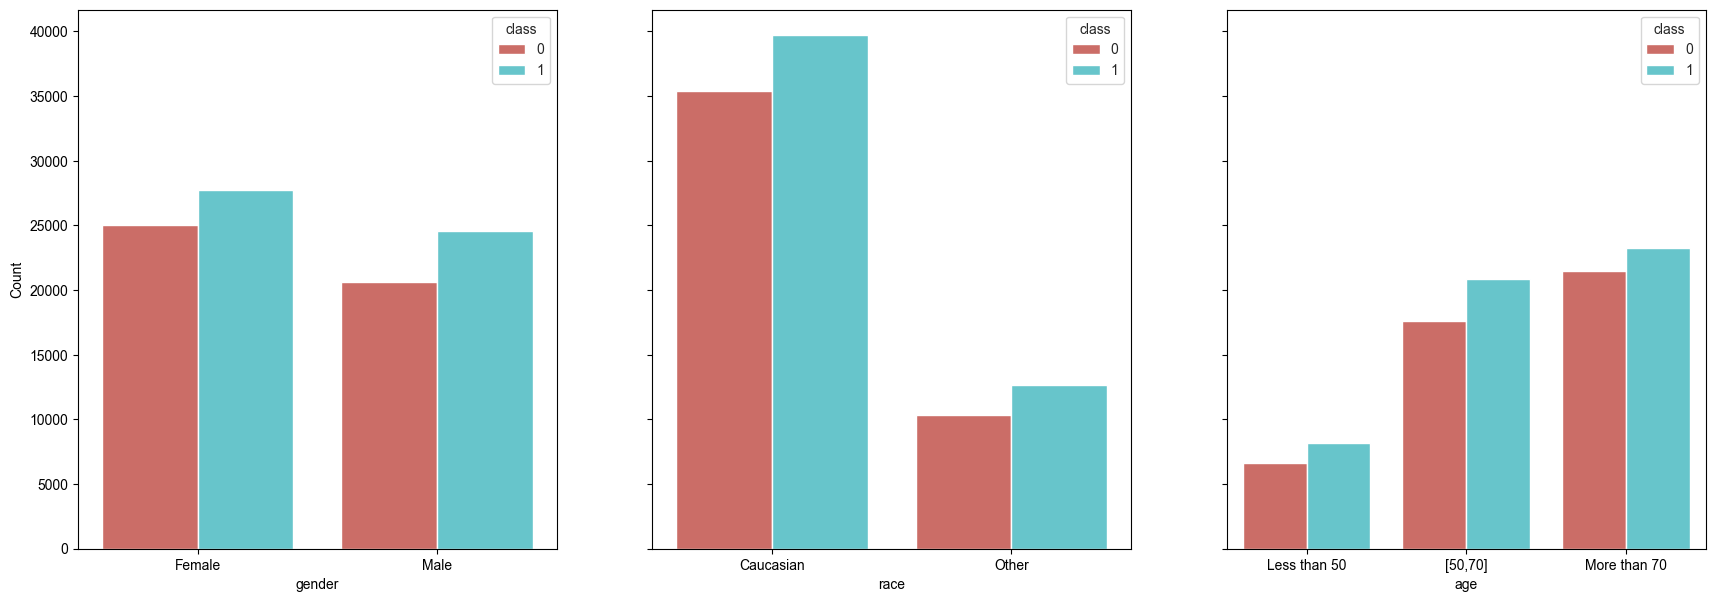

In [7]:
ml_ds = openml.datasets.get_dataset(45069)
df, * _ = ml_ds.get_data()

print(ml_ds.description[:700])
target = "class"
df[target] = df[target].replace('>30',0)
df[target] = df[target].replace('<30', 0)
df[target] = df[target].replace('NO', 1)
protected_attributes = ["gender","race","age"]
df['gender'] = df['gender'].replace('Unknown/Invalid', np.nan)

df['race'].replace('Unknown','Other',inplace=True)
df['race'].replace('Hispanic','Other',inplace=True)
df['race'].replace('Asian','Other',inplace=True)
df['race'].replace('AfricanAmerican','Other',inplace=True)

df['age'].replace("[70-80)","More than 70",inplace=True)
df['age'].replace("[80-90)","More than 70",inplace=True)
df['age'].replace("[90-100)","More than 70",inplace=True)

df['age'].replace("[60-70)","[50,70]",inplace=True)
df['age'].replace("[50-60)","[50,70]",inplace=True)

df['age'].replace("[40-50)","Less than 50",inplace=True)
df['age'].replace("[30-40)","Less than 50",inplace=True)
df['age'].replace("[20-30)", "Less than 50", inplace=True)
df['age'].replace("[10-20)","Less than 50",inplace=True)
df['age'].replace("[0-10)","Less than 50",inplace=True)

#df = df.dropna()  #dropping nans drops many race and gender entries from the unprotected groups. 
df = df.dropna(subset=['race'])
df = df.dropna(subset=['gender','diag_1','diag_2','diag_3'])

nan_columns =df.columns[df.isna().any()].tolist()
df.drop(columns=nan_columns, inplace=True)

def plot_attributes(dataset,attributes):
    fontsize = 10
    num_elements = len(attributes)
    num_cols = min(4, num_elements)  
    num_rows = math.ceil(num_elements / num_cols)
    
    fig_width = 7 * num_cols
    fig_height = 7 * num_rows
    
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), sharey=True, gridspec_kw={'hspace':0.5})
    ax = ax.flatten()
    plt.subplots_adjust(hspace = 1.5)
    sns.set_style("whitegrid")
    for i, attribute in enumerate(attributes):
        g0 = sns.countplot(x=attribute, data=dataset, palette="hls", 
                      ax=ax[i],hue=target) # order=dataset[attribute].value_counts().index)
        g0.set_xlabel(attribute, fontsize=fontsize)
        g0.set_ylabel("Count", fontsize=fontsize)
plot_attributes(df,protected_attributes)

In [28]:
df.dtypes

admission_type_id              uint8
discharge_disposition_id       uint8
admission_source_id            uint8
time_in_hospital               uint8
num_lab_procedures             uint8
num_procedures                 uint8
num_medications                uint8
number_outpatient              uint8
number_emergency               uint8
number_inpatient               uint8
number_diagnoses               uint8
race                        category
gender                      category
age                         category
diag_1                      category
diag_2                      category
diag_3                      category
max_glu_serum               category
A1Cresult                   category
metformin                   category
repaglinide                 category
nateglinide                 category
chlorpropamide              category
glimepiride                 category
acetohexamide               category
glipizide                   category
glyburide                   category
t

In [40]:
df[target].value_counts(normalize=True) * 100

0    53.37678
1    46.62322
Name: class, dtype: float64

In [8]:
# normalize data, convert to numerical
categorical_attributes = get_categorical_attributes(df)
df_num = df.copy()
encode_categorical_attributes(df_num, categorical_attributes)
scaler = MinMaxScaler()

for col in df_num.columns:
    if col not in categorical_attributes and col != target:
        df_num[col] = scaler.fit_transform(df_num[[col]])       

['race', 'gender', 'age', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide.metformin', 'glipizide.metformin', 'glimepiride.pioglitazone', 'metformin.rosiglitazone', 'metformin.pioglitazone', 'change', 'diabetesMed']
Attribute: race
{'Caucasian': 0, 'Other': 1}
Attribute: gender
{'Female': 0, 'Male': 1}
Attribute: age
{'Less than 50': 0, 'More than 70': 1, '[50,70]': 2}
Attribute: diag_1
{'10': 0, '11': 1, '110': 2, '112': 3, '114': 4, '115': 5, '117': 6, '131': 7, '133': 8, '135': 9, '136': 10, '141': 11, '142': 12, '143': 13, '145': 14, '146': 15, '147': 16, '148': 17, '149': 18, '150': 19, '151': 20, '152': 21, '153': 22, '154': 23, '155': 24, '156': 25, '157': 26, '158': 27, '160': 28, '161': 29, '162': 30, 

In [9]:
'''
Top 3 protected attributes: gender, race, age. Create new dataset with new columns containing the intersection of these attributes. Convert them to numerical.
'''
df_intersect = df.copy()
df_intersect["gender/race"] = df_intersect["gender"].astype(str) + " " + df_intersect["race"].astype(str)
df_intersect["gender/age"] = df_intersect["gender"].astype(str) + " " + df_intersect["age"].astype(str)
df_intersect["race/age"] = df_intersect["race"].astype(str) + " " + df_intersect["age"].astype(str)

df_intersect.drop(["race", "gender", "age"], axis=1, inplace=True)

categorical_attributes = get_categorical_attributes(df_intersect)
df_num_int = df_intersect.copy()
encode_categorical_attributes(df_num_int, categorical_attributes)
scaler = MinMaxScaler()

for col in df_num_int.columns:
    if col not in categorical_attributes and col != target:
     df_num_int[col] = scaler.fit_transform(df_num_int[[col]])
        
protected_attributes_int = ["gender/race","gender/age","race/age"]

['diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide.metformin', 'glipizide.metformin', 'glimepiride.pioglitazone', 'metformin.rosiglitazone', 'metformin.pioglitazone', 'change', 'diabetesMed', 'gender/race', 'gender/age', 'race/age']
Attribute: diag_1
{'10': 0, '11': 1, '110': 2, '112': 3, '114': 4, '115': 5, '117': 6, '131': 7, '133': 8, '135': 9, '136': 10, '141': 11, '142': 12, '143': 13, '145': 14, '146': 15, '147': 16, '148': 17, '149': 18, '150': 19, '151': 20, '152': 21, '153': 22, '154': 23, '155': 24, '156': 25, '157': 26, '158': 27, '160': 28, '161': 29, '162': 30, '163': 31, '164': 32, '170': 33, '171': 34, '172': 35, '173': 36, '174': 37, '175': 38, '179': 39, '180': 40, '182': 41, '183': 42, '184': 4

In [ ]:
plot_attributes(df_num_int,protected_attributes_int)

In [ ]:
corr = df_num_int.corr()
below_main_diagonal = corr.where(np.tril(np.ones(corr.shape), k=-1).astype(bool))
mask = pd.isna(below_main_diagonal) 
plt.figure(figsize=(25, 25))
sns.heatmap(below_main_diagonal.fillna(0),
            annot=True, 
            cmap="Purples",
            center=0, 
            mask=mask,
            vmin=below_main_diagonal.min().min(), 
            vmax=below_main_diagonal.max().max()
            )

In [10]:
list_of_disparities=["fnr_disparity"]
priv_orig, unpriv_orig = get_priv_and_unpriv_groups(protected_attribute=protected_attributes,data=df_num)
priv, unpriv = get_priv_and_unpriv_groups(protected_attribute=protected_attributes_int,data=df_num_int)


---------- Model name:  Catboost ----------

Accuracy score training:
0.6402
Accuracy score test:
0.6385
----------------------------------------

Classification report for model: <catboost.core.CatBoostClassifier object at 0x000002B0E5F2DBA0> : 
               precision    recall  f1-score   support

           0       0.64      0.50      0.56      9124
           1       0.64      0.76      0.69     10487

    accuracy                           0.64     19611
   macro avg       0.64      0.63      0.63     19611
weighted avg       0.64      0.64      0.63     19611



attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0         gender               0      0.64  0.75  0.52  0.36  0.36  0.48   
1         gender               1      0.64  0.77  0.48  0.36  0.36  0.52   
2           race               0      0.63  0.75  0.50  0.36  0.37  0.50   
3           race               1      0.65  0.78  0.49  0.35  0.35  0.51   
4            age               0      0.68  0.82  0.51  0.30  0.32  0.49   
5            age               1      0.61  0.72  0.50  0.38  0.39  0.50   
6            age               2      0.65  0.78  0.49  0.34  0.35  0.51   

    fnr   npv  precision   ppr  pprev  prev  
0  0.25  0.64       0.64  0.53   0.62  0.53  
1  0.23  0.64       0.64  0.47   0.66  0.54  
2  0.25  0.64       0.63  0.76   0.63  0.53  
3  0.22  0.65       0.65  0.24   0.66  0.55  
4  0.18  0.70       0.68  0.16   0.68  0.55  
5  0.28  0.62       0.61  0.44   0.61  0.52  
6  0.22  0.66       0.65  0.40   0.66  0.54

Majority class for:  gender  is: 0
Majority class for:  race  is: 0
Majority class for:  age  is: 1
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  for_disparity  \
0         gender               0           1.00           1.00           1.00   
1         gender               1           1.00           0.90           1.00   
2           race               0           1.00           1.00           1.00   
3           race               1           0.94           0.87           0.97   
4            age               0           0.83           0.63           0.80   
5            age               1           1.00           1.00           1.00   
6            age               2           0.91           0.78           0.91   

   fpr_disparity  npv_disparity  ppr_disparity  pprev_disparity  \
0           1.00           1.00           1.00             1.00   
1           1.07           1.00           0.90             1.05   
2           1.00           1.00           1.00             1.00   
3           1.02           1.02           0.32             1.04   
4           0.98           1.13           0.36             1.10   
5           1.00           1.00           1.00             1.00   
6           1.01           1.06           0.92             1.07   

   precision_disparity  tnr_disparity  tpr_disparity  
0                 1.00           1.00           1.00  
1                 1.00           0.93           1.03  
2                 1.00           1.00           1.00  
3                 1.03           0.98           1.04  
4                 1.11           1.02           1.15  
5                 1.00           1.00           1.00  
6                 1.06           0.99           1.09

        fnr_disparity
age             0.705
gender          0.900
race            0.870
Overall average for fnr_disparity:  0.825


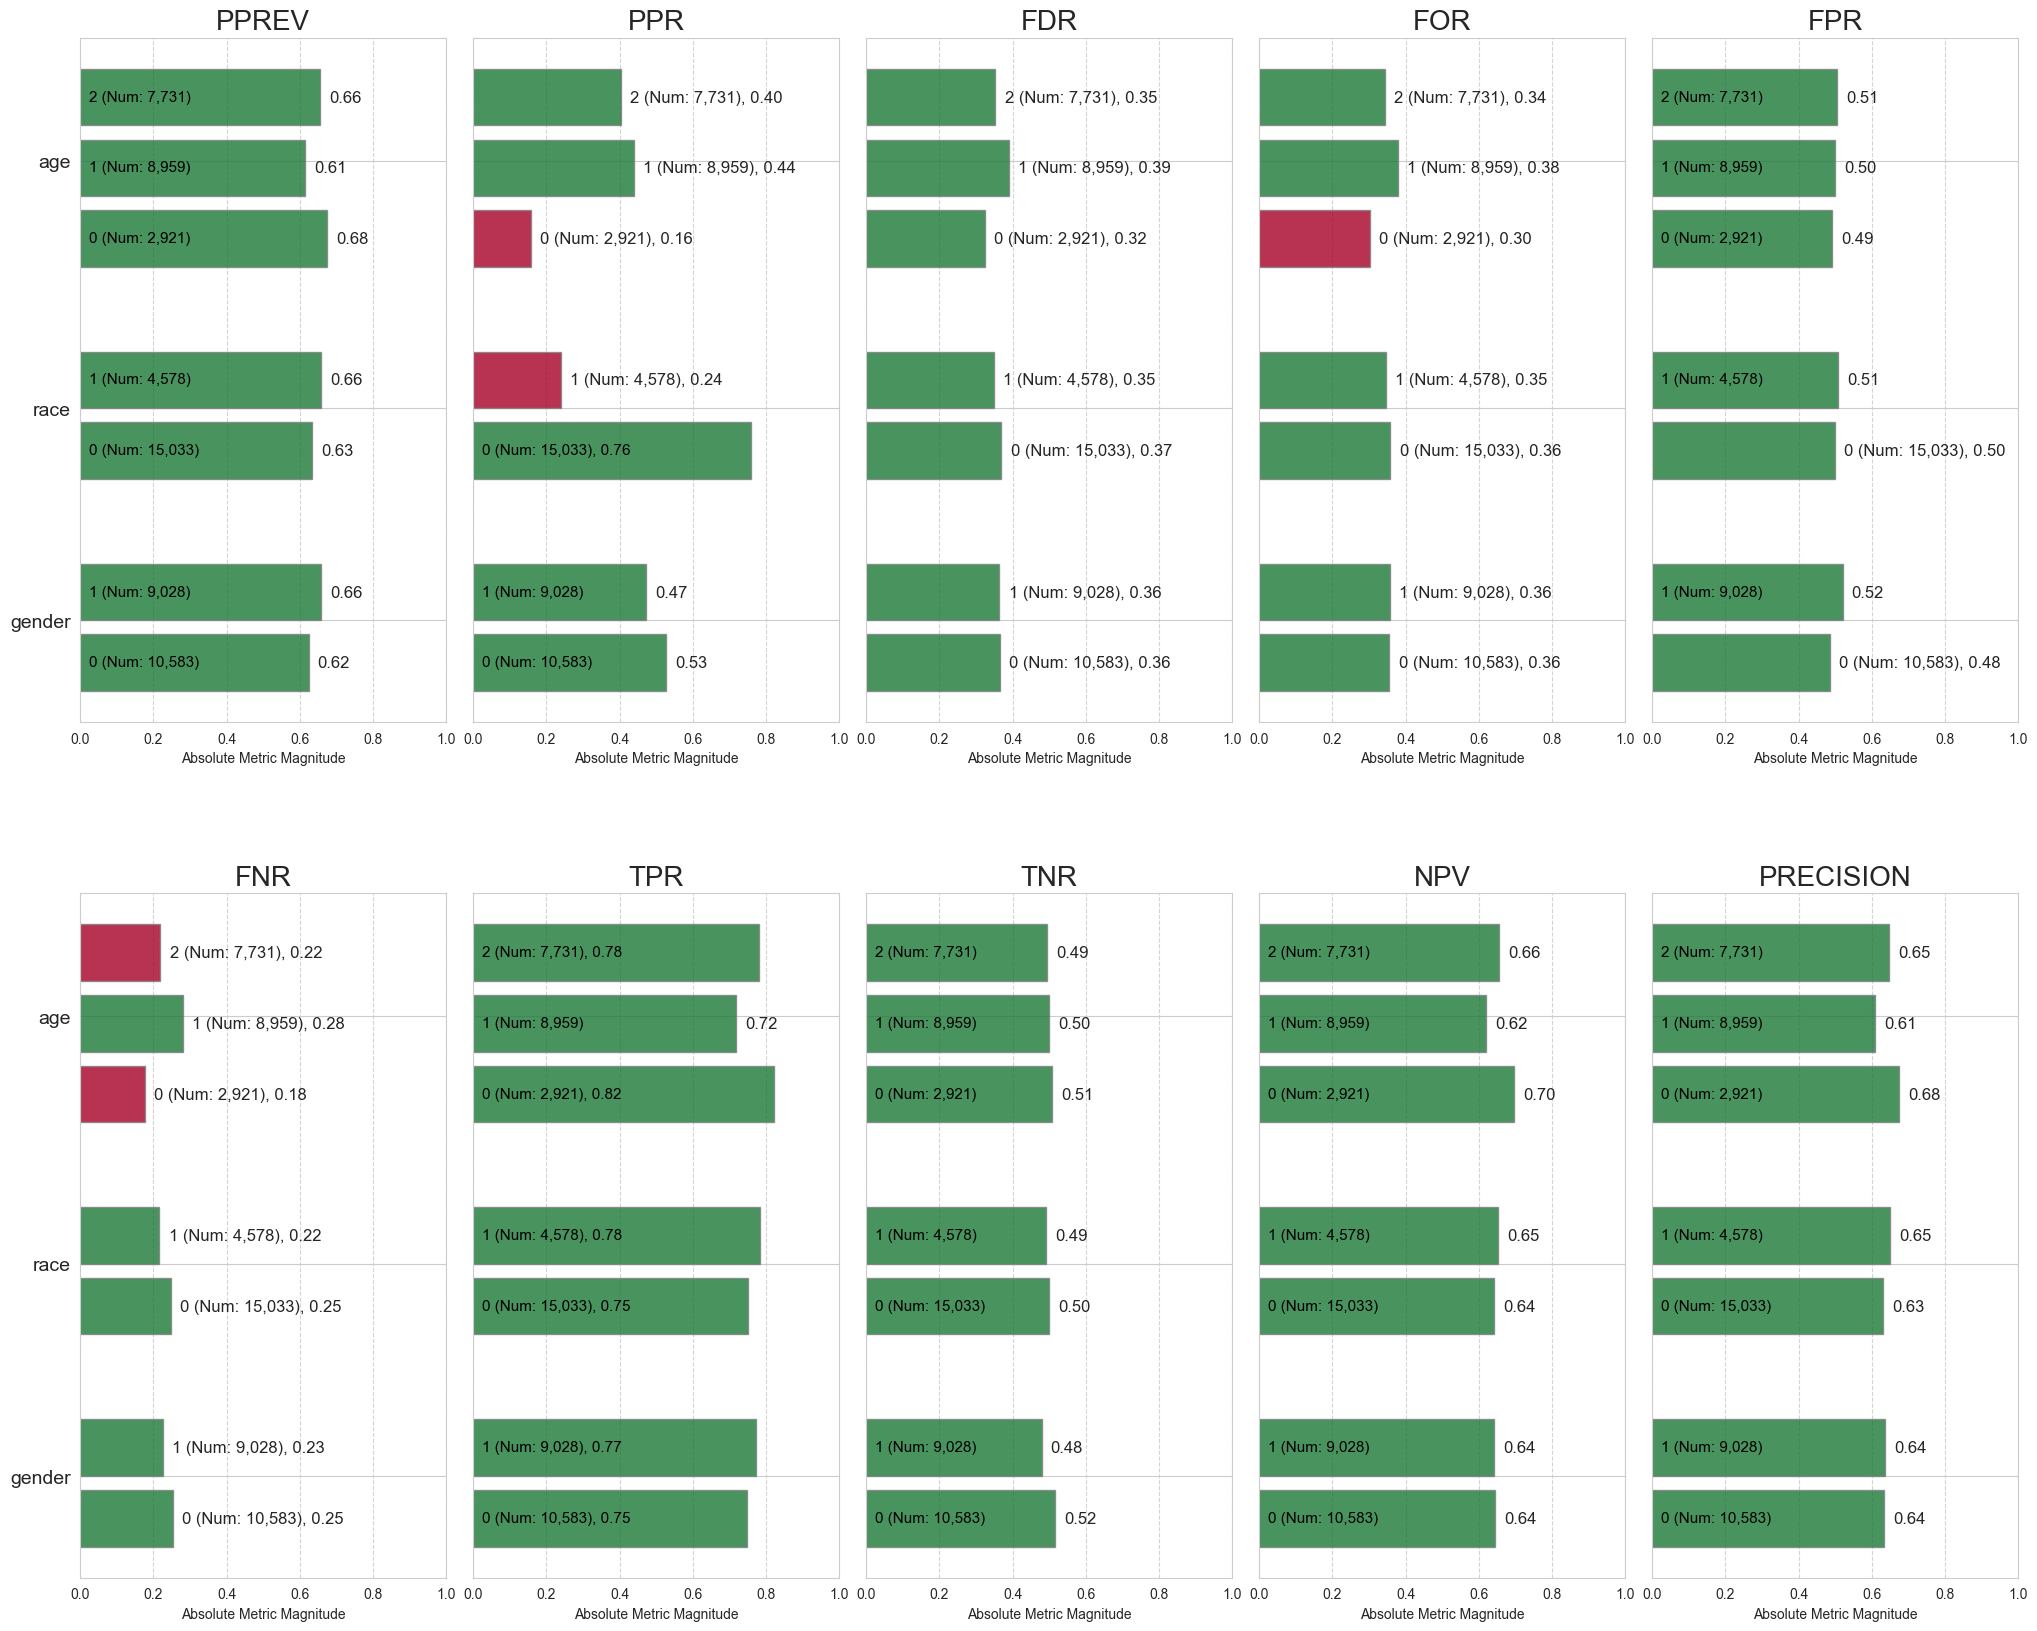

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1            age               False           True   
1         0      binary 0/1         gender                True           True   
2         0      binary 0/1           race               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0        True        True       False       False        True        True   
1        True        True        True        True        True        True   
2        True        True        True        True        True        True   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0        True              True          True          False            True   
1        True              True          True           True            True   
2        True              True          True           True            True   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                   True                 True  
2                  False                 True

<Figure size 640x480 with 0 Axes>

In [7]:
"""
Train and calculate fairness metrics for original dataset.
"""
x_test, y_test, y_predicted_dict, metrics_dict = split_and_train(df_num,protected_attributes,target)
df_test = calc_fairness_report(x_test, y_test, y_predicted_dict['Catboost'], target, protected_attributes, list_of_disparities, priv_orig,display_disp=True)

In [53]:
plot_audit(df_test, protected_attributes)

alt.VConcatChart(...)

---------- Model name:  Catboost ----------

Accuracy score training:
0.6397
Accuracy score test:
0.6378
----------------------------------------

Classification report for model: <catboost.core.CatBoostClassifier object at 0x000001CE7097F970> : 
               precision    recall  f1-score   support

           0       0.64      0.50      0.56      9124
           1       0.63      0.76      0.69     10487

    accuracy                           0.64     19611
   macro avg       0.64      0.63      0.63     19611
weighted avg       0.64      0.64      0.63     19611



attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0     gender/race               0      0.63  0.73  0.52  0.36  0.37  0.48   
1     gender/race               1      0.65  0.79  0.48  0.34  0.35  0.52   
2     gender/race               2      0.63  0.77  0.47  0.36  0.37  0.53   
3     gender/race               3      0.66  0.79  0.49  0.34  0.34  0.51   
4      gender/age               0      0.69  0.81  0.52  0.32  0.31  0.48   
5      gender/age               1      0.61  0.71  0.51  0.38  0.39  0.49   
6      gender/age               2      0.65  0.77  0.51  0.34  0.36  0.49   
7      gender/age               3      0.68  0.82  0.50  0.29  0.34  0.50   
8      gender/age               4      0.62  0.73  0.49  0.38  0.39  0.51   
9      gender/age               5      0.64  0.80  0.45  0.35  0.36  0.55   
10       race/age               0      0.68  0.82  0.50  0.31  0.33  0.50   
11       race/age               1      0.61  0.71  0.51  0.38  0.39  0.49   
12       race/age               2      0.64  0.78  0.48  0.35  0.36  0.52   
13       race/age               3      0.69  0.82  0.53  0.30  0.31  0.47   
14       race/age               4      0.62  0.75  0.46  0.39  0.38  0.54   
15       race/age               5      0.66  0.80  0.49  0.33  0.35  0.51   

     fnr   npv  precision   ppr  pprev  prev  
0   0.27  0.64       0.63  0.38   0.61  0.52  
1   0.21  0.66       0.65  0.14   0.67  0.55  
2   0.23  0.64       0.63  0.38   0.66  0.54  
3   0.21  0.66       0.66  0.10   0.66  0.55  
4   0.19  0.68       0.69  0.08   0.67  0.57  
5   0.29  0.62       0.61  0.25   0.60  0.52  
6   0.23  0.66       0.64  0.19   0.64  0.53  
7   0.18  0.71       0.66  0.07   0.67  0.54  
8   0.27  0.62       0.61  0.18   0.63  0.53  
9   0.20  0.65       0.64  0.22   0.69  0.55  
10  0.18  0.69       0.67  0.10   0.67  0.55  
11  0.29  0.62       0.61  0.36   0.60  0.52  
12  0.22  0.65       0.64  0.30   0.66  0.54  
13  0.18  0.70       0.69  0.06   0.67  0.56  
14  0.25  0.61       0.62  0.08   0.66  0.54  
15  0.20  0.67       0.65  0.11   0.67  0.55

Majority class for:  gender/race  is: 0
Majority class for:  gender/age  is: 1
Majority class for:  race/age  is: 1
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0     gender/race               0           1.00           1.00   
1     gender/race               1           0.95           0.78   
2     gender/race               2           1.00           0.85   
3     gender/race               3           0.93           0.79   
4      gender/age               0           0.79           0.64   
5      gender/age               1           1.00           1.00   
6      gender/age               2           0.91           0.78   
7      gender/age               3           0.86           0.60   
8      gender/age               4           0.99           0.92   
9      gender/age               5           0.91           0.68   
10       race/age               0           0.84           0.63   
11       race/age               1           1.00           1.00   
12       race/age               2           0.92           0.75   
13       race/age               3           0.80           0.62   
14       race/age               4           0.97           0.85   
15       race/age               5           0.88           0.69   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.00           1.00           1.00           1.00   
1            0.95           1.08           1.03           0.38   
2            1.00           1.12           1.00           0.99   
3            0.95           1.06           1.03           0.26   
4            0.84           0.98           1.09           0.32   
5            1.00           1.00           1.00           1.00   
6            0.89           1.00           1.07           0.76   
7            0.77           1.02           1.14           0.29   
8            1.01           1.06           0.99           0.73   
9            0.93           1.13           1.04           0.86   
10           0.82           1.01           1.11           0.27   
11           1.00           1.00           1.00           1.00   
12           0.92           1.06           1.05           0.84   
13           0.79           0.96           1.13           0.16   
14           1.02           1.10           0.99           0.21   
15           0.88           1.04           1.07           0.30   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              1.00                 1.00           1.00           1.00  
1              1.09                 1.03           0.93           1.08  
2              1.08                 1.00           0.90           1.06  
3              1.08                 1.04           0.94           1.08  
4              1.11                 1.13           1.02           1.15  
5              1.00                 1.00           1.00           1.00  
6              1.06                 1.06           1.00           1.09  
7              1.12                 1.09           0.98           1.16  
8              1.04                 1.01           0.95           1.03  
9              1.14                 1.05           0.88           1.13  
10             1.11                 1.10           0.99           1.15  
11             1.00                 1.00           1.00           1.00  
12             1.10                 1.05           0.94           1.10  
13             1.10                 1.13           1.03           1.15  
14             1.09                 1.02           0.90           1.06  
15             1.11                 1.07           0.96           1.13

             fnr_disparity
gender/age        0.724000
gender/race       0.806667
race/age          0.708000
Overall average for fnr_disparity:  0.746


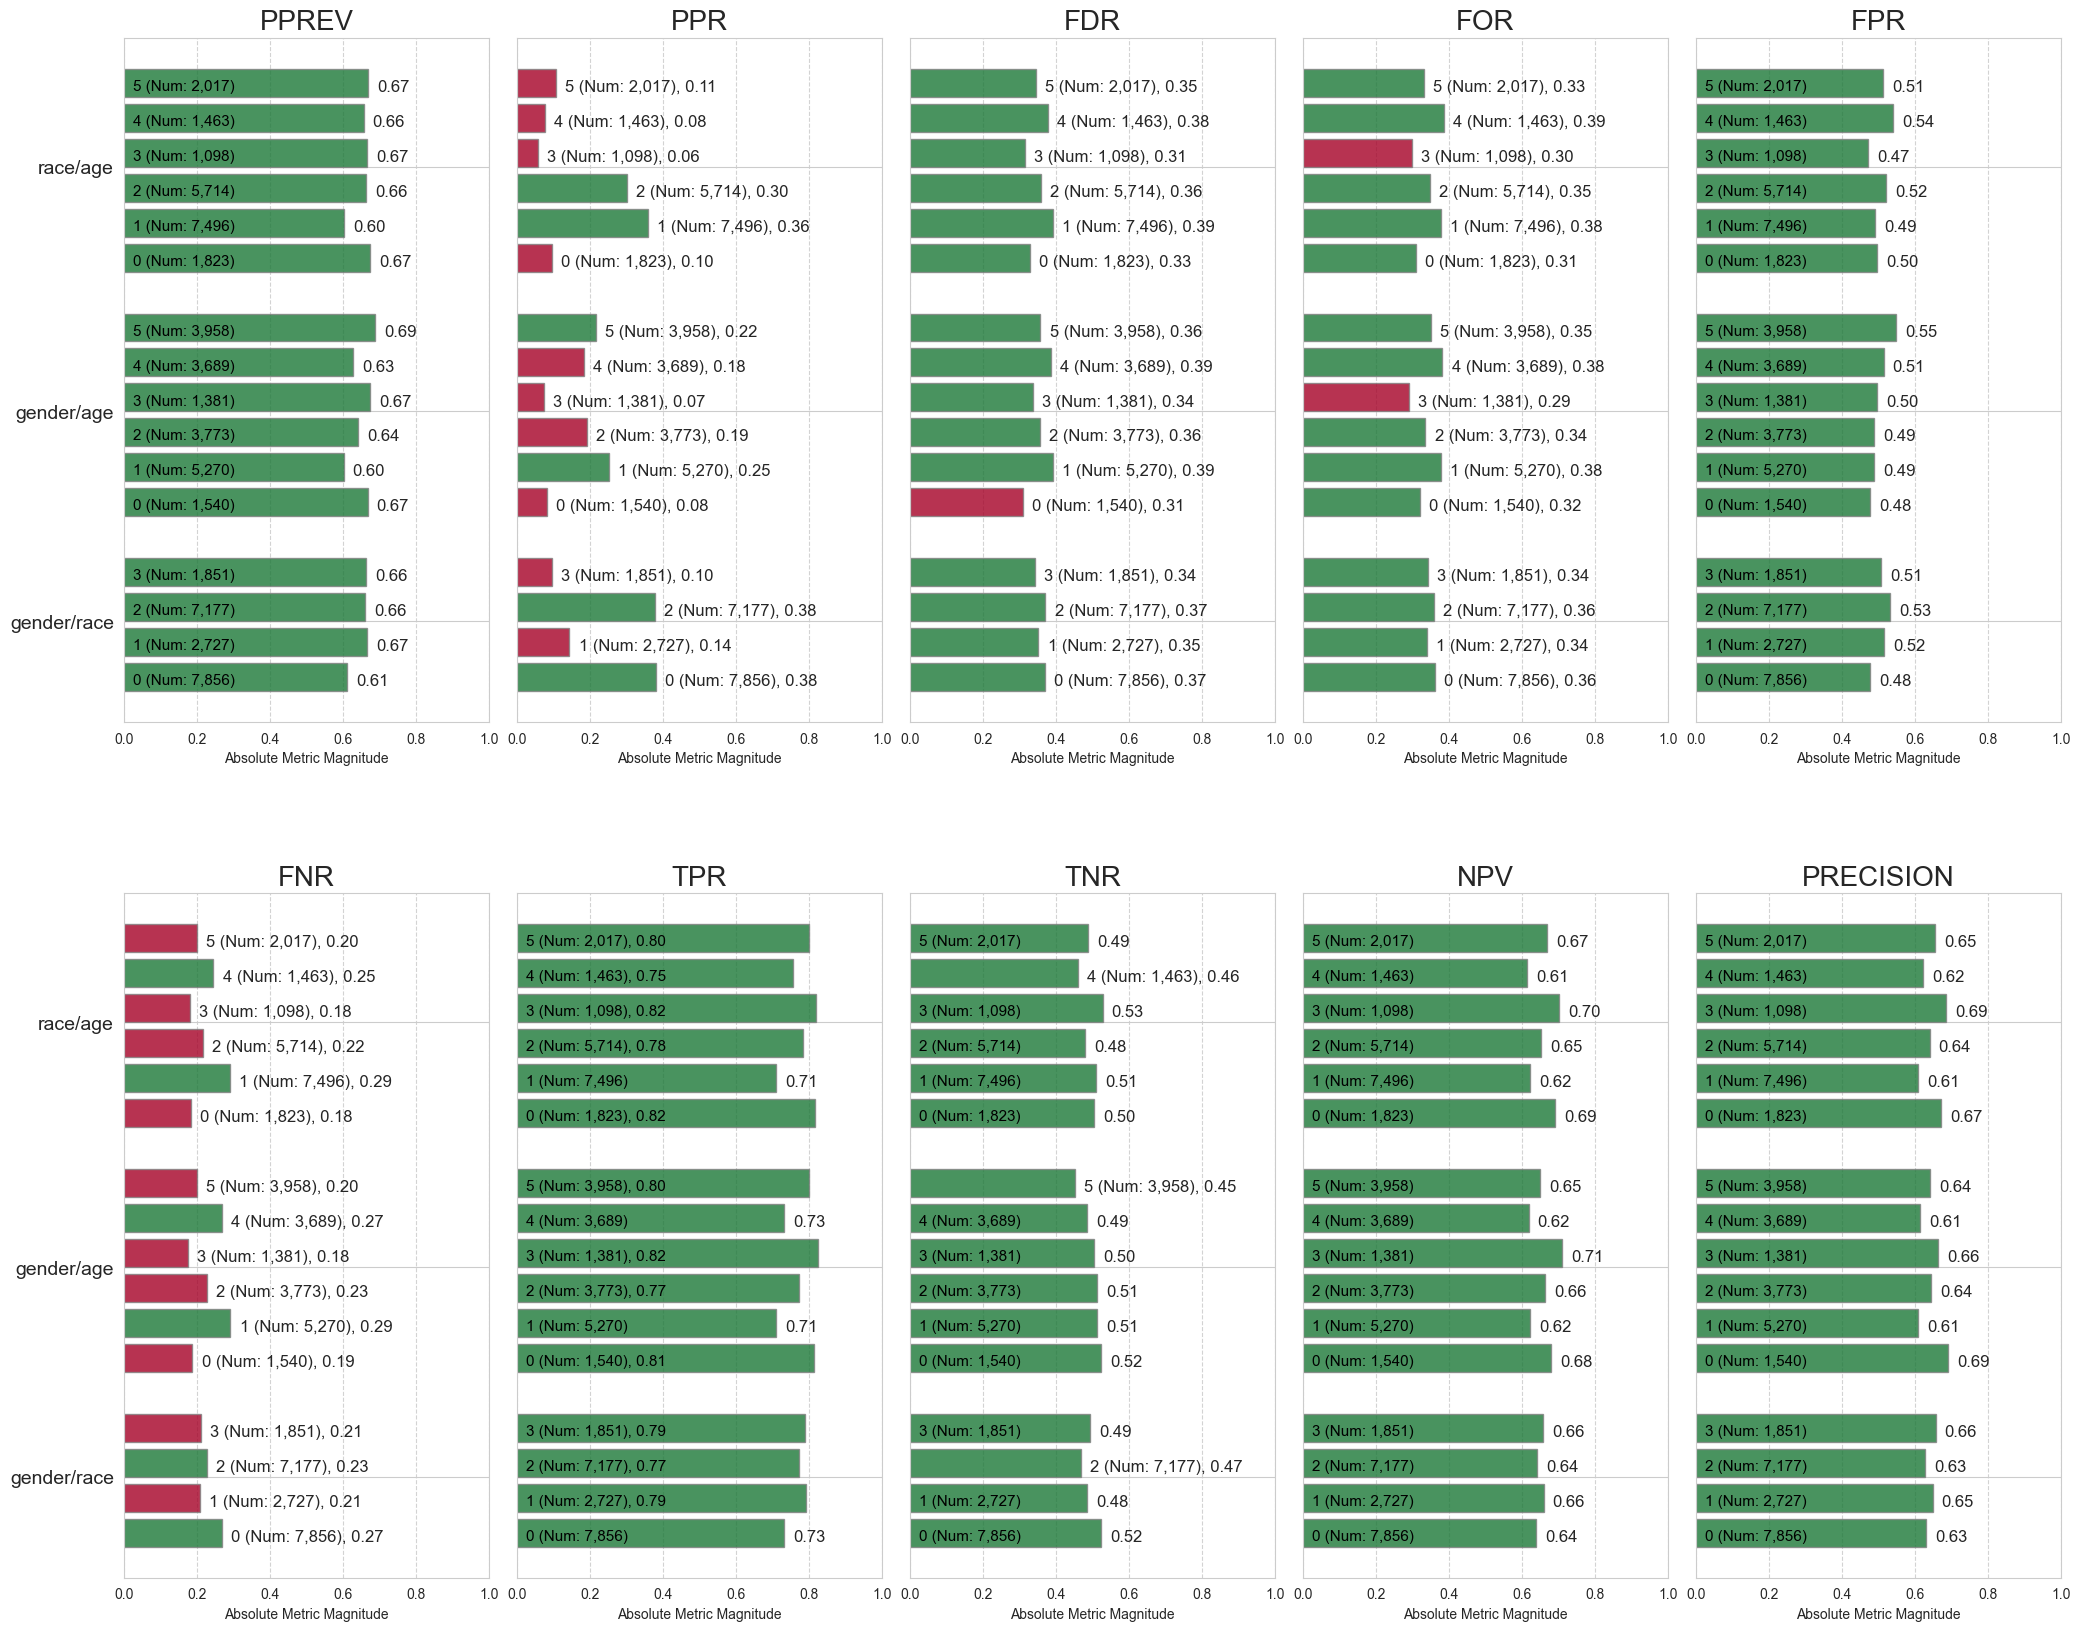

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1     gender/age               False           True   
1         0      binary 0/1    gender/race               False           True   
2         0      binary 0/1       race/age               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False        True       False       False        True        True   
1        True        True        True       False        True        True   
2        True        True       False       False        True        True   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0        True              True         False          False            True   
1        True              True          True          False            True   
2        True              True          True          False            True   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                False  
2                  False                False

<Figure size 640x480 with 0 Axes>

In [11]:
"""
Train and calculate fariness metrics for the dataset obtained by the intersection of protected attributes.
"""
x_test_int, y_test_int, y_predicted_dict_int, metrics_dict_int = split_and_train(df_num_int,protected_attributes_int,target)
df_test_int = calc_fairness_report(x_test_int, y_test_int, y_predicted_dict_int['Catboost'], target, protected_attributes_int,list_of_disparities, priv,display_disp=True)

---------- Model name:  Catboost ----------

Accuracy score training:
0.6640
Accuracy score test:
0.6633
----------------------------------------

Classification report for model: <catboost.core.CatBoostClassifier object at 0x000002B0E378CEB0> : 
               precision    recall  f1-score   support

           0       0.68      0.53      0.60      9163
           1       0.65      0.78      0.71     10448

    accuracy                           0.66     19611
   macro avg       0.67      0.66      0.65     19611
weighted avg       0.67      0.66      0.66     19611



attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0     gender/race               0      0.66  0.76  0.54  0.34  0.34  0.46   
1     gender/race               1      0.67  0.80  0.54  0.30  0.34  0.46   
2     gender/race               2      0.66  0.79  0.51  0.32  0.35  0.49   
3     gender/race               3      0.68  0.80  0.56  0.30  0.33  0.44   
4      gender/age               0      0.72  0.84  0.57  0.25  0.30  0.43   
5      gender/age               1      0.64  0.74  0.52  0.37  0.36  0.48   
6      gender/age               2      0.68  0.80  0.55  0.30  0.34  0.45   
7      gender/age               3      0.70  0.85  0.54  0.23  0.34  0.46   
8      gender/age               4      0.65  0.75  0.53  0.34  0.36  0.47   
9      gender/age               5      0.67  0.81  0.51  0.31  0.34  0.49   
10       race/age               0      0.71  0.85  0.54  0.24  0.32  0.46   
11       race/age               1      0.64  0.74  0.53  0.36  0.36  0.47   
12       race/age               2      0.67  0.80  0.52  0.31  0.34  0.48   
13       race/age               3      0.71  0.83  0.58  0.25  0.32  0.42   
14       race/age               4      0.66  0.77  0.53  0.33  0.36  0.47   
15       race/age               5      0.68  0.80  0.54  0.30  0.33  0.46   

     fnr   npv  precision   ppr  pprev  prev  
0   0.24  0.66       0.66  0.39   0.62  0.54  
1   0.20  0.70       0.66  0.14   0.64  0.53  
2   0.21  0.68       0.65  0.37   0.65  0.53  
3   0.20  0.70       0.67  0.09   0.63  0.53  
4   0.16  0.75       0.70  0.08   0.65  0.55  
5   0.26  0.63       0.64  0.26   0.61  0.53  
6   0.20  0.70       0.66  0.19   0.64  0.53  
7   0.15  0.77       0.66  0.07   0.66  0.51  
8   0.25  0.66       0.64  0.18   0.62  0.53  
9   0.19  0.69       0.66  0.21   0.66  0.54  
10  0.15  0.76       0.68  0.10   0.67  0.54  
11  0.26  0.64       0.64  0.37   0.61  0.53  
12  0.20  0.69       0.66  0.30   0.65  0.54  
13  0.17  0.75       0.68  0.06   0.64  0.53  
14  0.23  0.67       0.64  0.07   0.63  0.53  
15  0.20  0.70       0.67  0.10   0.64  0.54

Majority class for:  gender/race  is: 0
Majority class for:  gender/age  is: 1
Majority class for:  race/age  is: 1
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0     gender/race               0           1.00           1.00   
1     gender/race               1           0.99           0.86   
2     gender/race               2           1.03           0.90   
3     gender/race               3           0.95           0.86   
4      gender/age               0           0.82           0.60   
5      gender/age               1           1.00           1.00   
6      gender/age               2           0.92           0.77   
7      gender/age               3           0.93           0.58   
8      gender/age               4           0.99           0.95   
9      gender/age               5           0.94           0.73   
10       race/age               0           0.88           0.56   
11       race/age               1           1.00           1.00   
12       race/age               2           0.94           0.75   
13       race/age               3           0.87           0.65   
14       race/age               4           0.98           0.87   
15       race/age               5           0.92           0.76   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.00           1.00           1.00           1.00   
1            0.88           1.00           1.06           0.36   
2            0.95           1.05           1.03           0.95   
3            0.88           0.96           1.06           0.24   
4            0.69           0.90           1.18           0.31   
5            1.00           1.00           1.00           1.00   
6            0.81           0.95           1.11           0.74   
7            0.63           0.97           1.21           0.28   
8            0.94           0.97           1.04           0.70   
9            0.85           1.03           1.09           0.81   
10           0.66           0.97           1.19           0.27   
11           1.00           1.00           1.00           1.00   
12           0.84           1.01           1.09           0.81   
13           0.68           0.89           1.18           0.15   
14           0.90           0.99           1.06           0.20   
15           0.83           0.98           1.09           0.28   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              1.00                 1.00           1.00           1.00  
1              1.02                 1.00           1.00           1.04  
2              1.04                 0.99           0.96           1.03  
3              1.01                 1.03           1.03           1.04  
4              1.06                 1.11           1.09           1.14  
5              1.00                 1.00           1.00           1.00  
6              1.03                 1.04           1.05           1.08  
7              1.07                 1.04           1.03           1.15  
8              1.00                 1.01           1.02           1.02  
9              1.08                 1.04           0.97           1.10  
10             1.09                 1.07           1.03           1.16  
11             1.00                 1.00           1.00           1.00  
12             1.06                 1.04           0.99           1.09  
13             1.04                 1.07           1.10           1.13  
14             1.03                 1.01           1.00           1.05  
15             1.05                 1.05           1.02           1.09

             fnr_disparity
gender/age        0.726000
gender/race       0.873333
race/age          0.718000
Overall average for fnr_disparity:  0.772


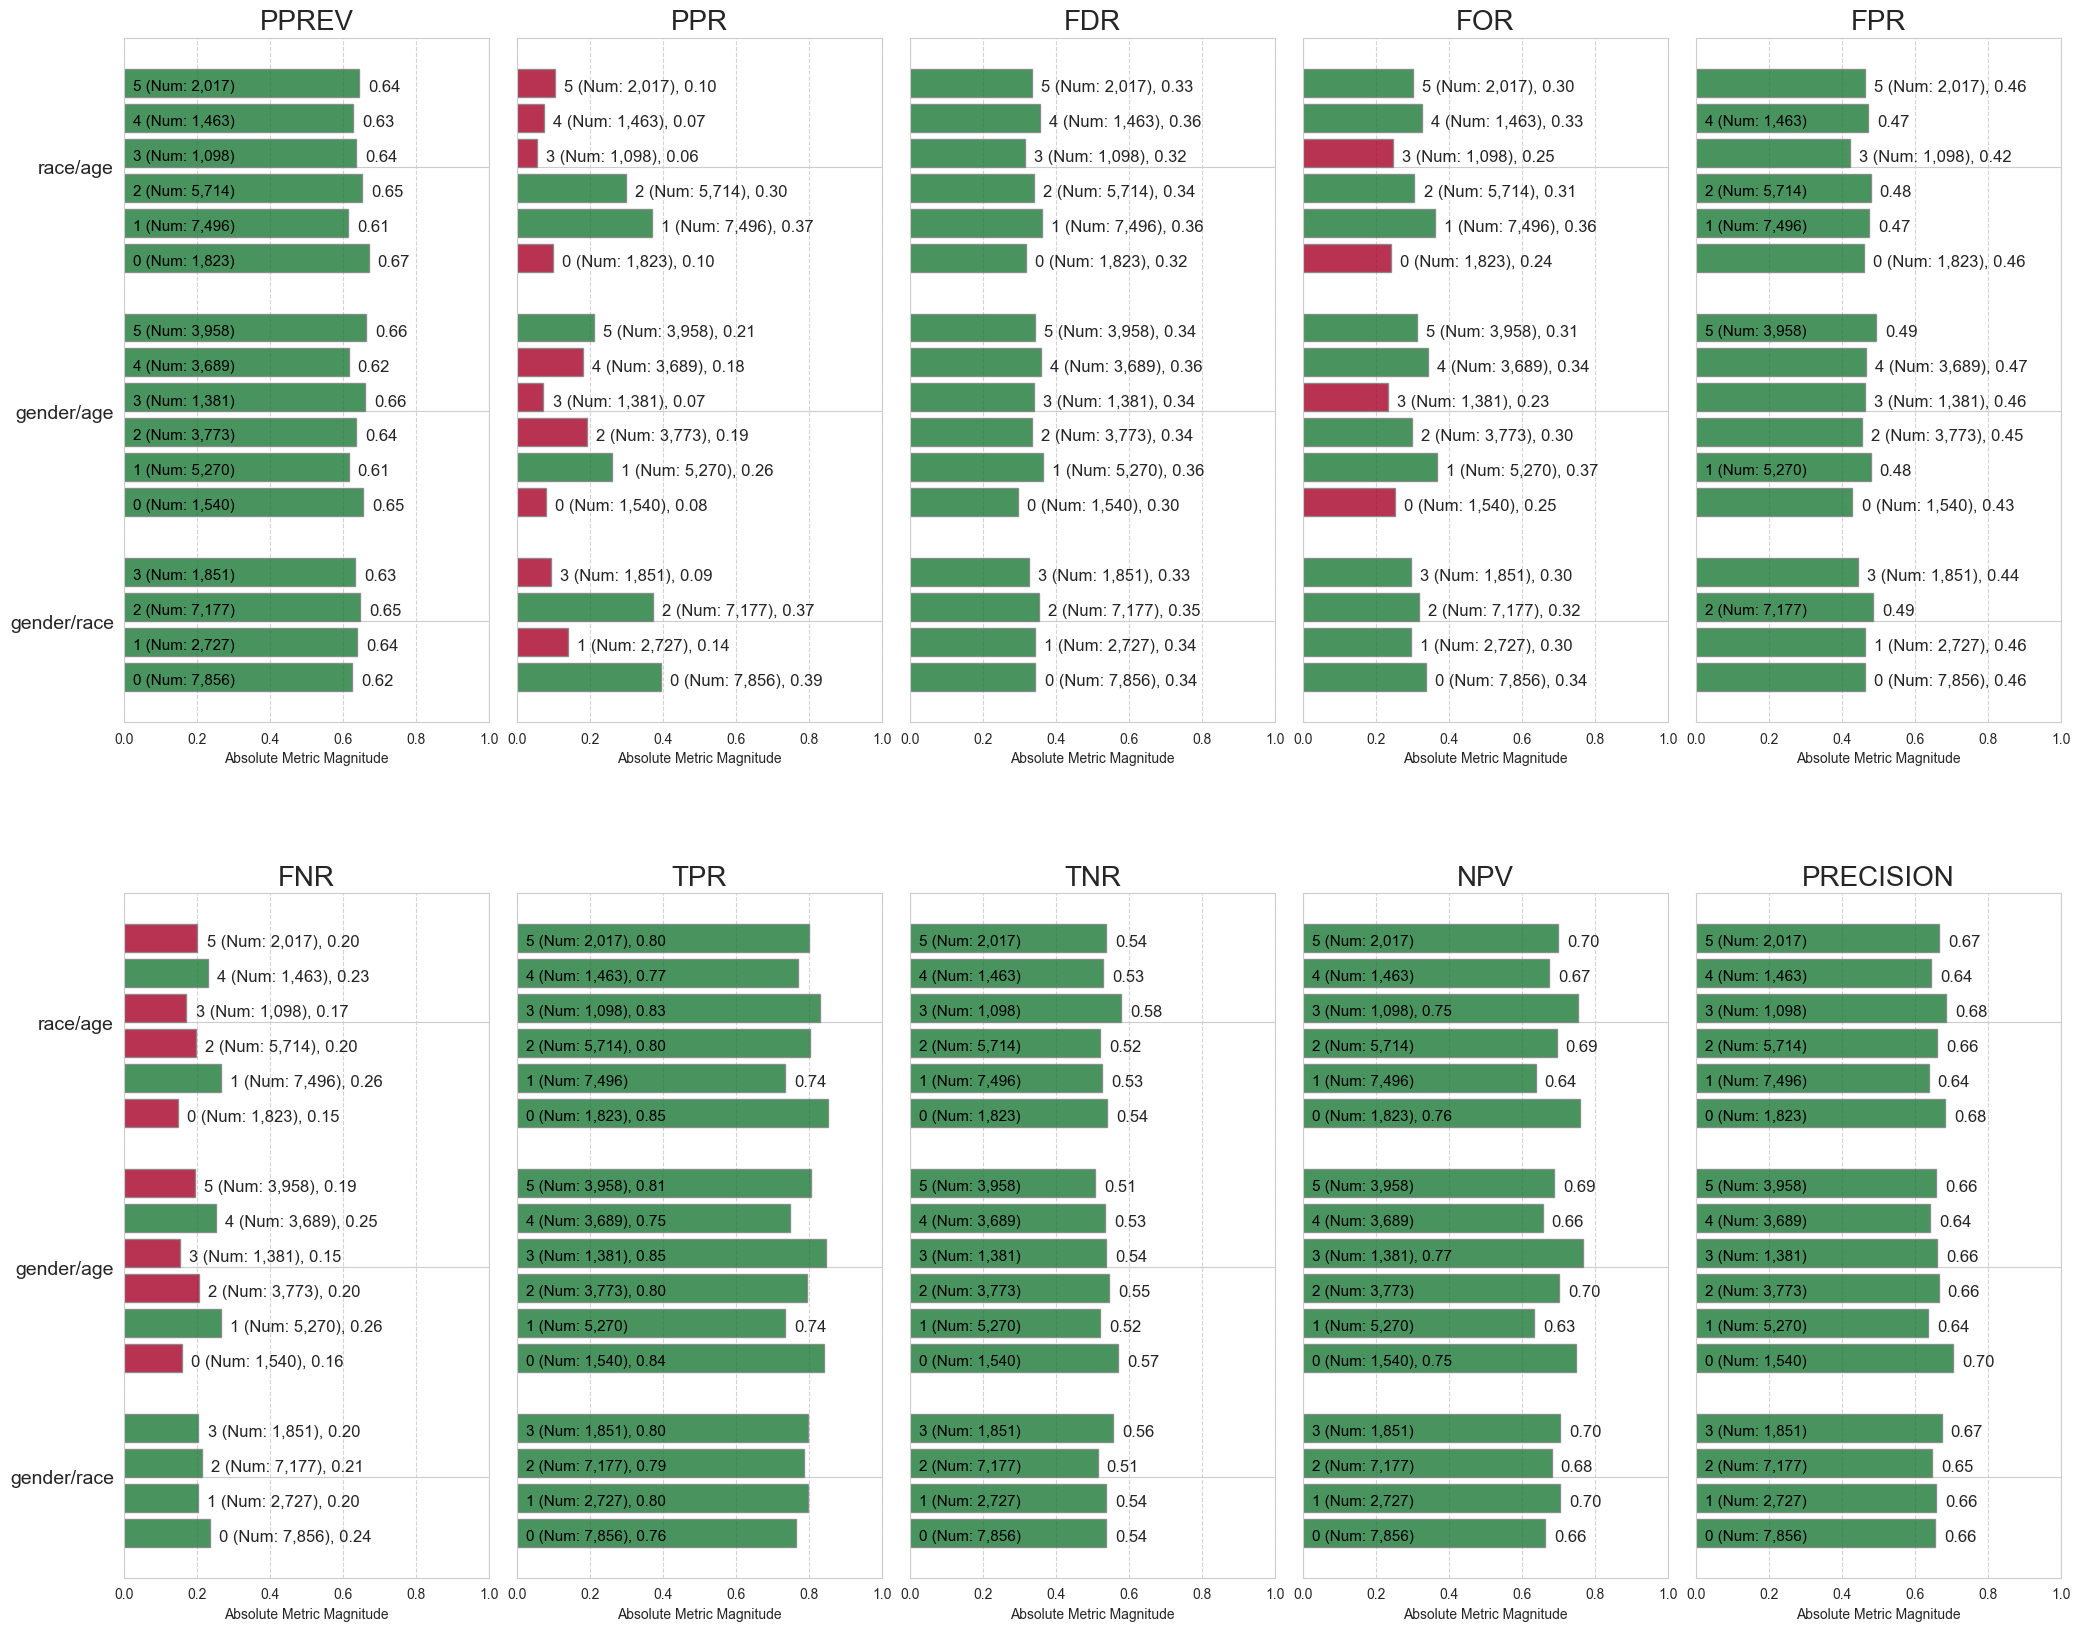

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1     gender/age               False           True   
1         0      binary 0/1    gender/race               False           True   
2         0      binary 0/1       race/age               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0        True        True       False       False        True        True   
1        True        True        True        True        True        True   
2        True        True       False       False        True        True   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0        True              True          True          False            True   
1        True              True          True           True            True   
2        True              True          True          False            True   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                 True  
2                  False                False

<Figure size 640x480 with 0 Axes>

In [9]:
'''
1: Massaging method (Flips selected labels to reduce prevalence disparity between groups), train and calculate metrics.
'''
#transform data
data_to_transform = df_num_int.copy()
data_transformed_m = prep_massaging(data_to_transform, protected_attributes_int, target)

#train on the transformed dataset
x_test_ms, y_test_ms, y_predicted_dict_transformed, metrics_ms_dict = split_and_train(data_transformed_m,protected_attributes_int,target)
#calculate the fairness report
df_test_transformed =calc_fairness_report(x_test_ms, y_test_ms, y_predicted_dict_transformed["Catboost"],target,protected_attributes_int,list_of_disparities,priv,display_disp=True)

In [21]:
# compare disparities to the original dataset
plot_audit(df_test, protected_attributes)
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed, protected_attributes_int)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

[INFO] 2024-11-20 20:51:07 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-11-20 20:51:07 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-11-20 20:51:07 methods.preprocessing.PrevalenceSampling - Original group 1 size: 13659


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 13659


[INFO] 2024-11-20 20:51:07 methods.preprocessing.PrevalenceSampling - Final group 1 size: 13277


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 13277


[INFO] 2024-11-20 20:51:07 methods.preprocessing.PrevalenceSampling - Original group 0 size: 39174


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 39174


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Final group 0 size: 38035


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 38035


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Original group 2 size: 35905


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 35905


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Final group 2 size: 35420


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 35420


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Original group 3 size: 9314


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 9314


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Final group 3 size: 8878


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 8878


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Original group 2 size: 18538


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 18538


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Final group 2 size: 18536


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 18536


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Original group 1 size: 25039


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 25039


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Final group 1 size: 24763


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 24763


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Original group 0 size: 7735


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 7735


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Final group 0 size: 7417


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 7417


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Original group 5 size: 19034


INFO:methods.preprocessing.PrevalenceSampling:Original group 5 size: 19034


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Final group 5 size: 18465


INFO:methods.preprocessing.PrevalenceSampling:Final group 5 size: 18465


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Original group 4 size: 18595


INFO:methods.preprocessing.PrevalenceSampling:Original group 4 size: 18595


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Final group 4 size: 17942


INFO:methods.preprocessing.PrevalenceSampling:Final group 4 size: 17942


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Original group 3 size: 6669


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 6669


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Final group 3 size: 6490


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 6490


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Original group 5 size: 9774


INFO:methods.preprocessing.PrevalenceSampling:Original group 5 size: 9774


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Final group 5 size: 9658


INFO:methods.preprocessing.PrevalenceSampling:Final group 5 size: 9658


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Original group 2 size: 27227


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 27227


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Final group 2 size: 27094


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 27094


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Original group 4 size: 6873


INFO:methods.preprocessing.PrevalenceSampling:Original group 4 size: 6873


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Final group 4 size: 6846


INFO:methods.preprocessing.PrevalenceSampling:Final group 4 size: 6846


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Original group 3 size: 5078


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 5078


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Final group 3 size: 5038


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 5038


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Original group 1 size: 35832


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 35832


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Final group 1 size: 35809


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 35809


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Original group 0 size: 8829


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 8829


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Final group 0 size: 8783


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 8783


[INFO] 2024-11-20 20:51:08 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


---------- Model name:  Catboost ----------

Accuracy score training:
0.6379
Accuracy score test:
0.6378
----------------------------------------

Classification report for model: <catboost.core.CatBoostClassifier object at 0x000002B0E487BD30> : 
               precision    recall  f1-score   support

           0       0.64      0.49      0.56      8654
           1       0.63      0.76      0.69      9992

    accuracy                           0.64     18646
   macro avg       0.64      0.63      0.63     18646
weighted avg       0.64      0.64      0.63     18646



attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0     gender/race               0      0.65  0.76  0.51  0.35  0.36  0.49   
1     gender/race               1      0.63  0.77  0.48  0.35  0.38  0.52   
2     gender/race               2      0.63  0.76  0.47  0.38  0.37  0.53   
3     gender/race               3      0.66  0.79  0.51  0.34  0.34  0.49   
4      gender/age               0      0.68  0.82  0.53  0.27  0.34  0.47   
5      gender/age               1      0.63  0.74  0.50  0.38  0.37  0.50   
6      gender/age               2      0.65  0.77  0.51  0.33  0.37  0.49   
7      gender/age               3      0.67  0.82  0.50  0.31  0.34  0.50   
8      gender/age               4      0.61  0.74  0.47  0.39  0.38  0.53   
9      gender/age               5      0.64  0.78  0.47  0.36  0.36  0.53   
10       race/age               0      0.68  0.83  0.50  0.29  0.34  0.50   
11       race/age               1      0.63  0.74  0.49  0.38  0.37  0.51   
12       race/age               2      0.64  0.77  0.48  0.35  0.37  0.52   
13       race/age               3      0.68  0.81  0.53  0.29  0.34  0.47   
14       race/age               4      0.61  0.74  0.46  0.40  0.39  0.54   
15       race/age               5      0.65  0.78  0.50  0.33  0.36  0.50   

     fnr   npv  precision   ppr  pprev  prev  
0   0.24  0.65       0.64  0.39   0.63  0.53  
1   0.23  0.65       0.62  0.14   0.65  0.53  
2   0.24  0.62       0.63  0.38   0.66  0.54  
3   0.21  0.66       0.66  0.09   0.65  0.55  
4   0.18  0.73       0.66  0.08   0.66  0.52  
5   0.26  0.62       0.63  0.26   0.63  0.54  
6   0.23  0.67       0.63  0.19   0.64  0.53  
7   0.18  0.69       0.66  0.07   0.68  0.55  
8   0.26  0.61       0.62  0.19   0.64  0.54  
9   0.22  0.64       0.64  0.20   0.66  0.54  
10  0.17  0.71       0.66  0.10   0.67  0.54  
11  0.26  0.62       0.63  0.38   0.63  0.54  
12  0.23  0.65       0.63  0.29   0.65  0.53  
13  0.19  0.71       0.66  0.05   0.65  0.53  
14  0.26  0.60       0.61  0.07   0.65  0.54  
15  0.22  0.67       0.64  0.10   0.65  0.53

Majority class for:  gender/race  is: 0
Majority class for:  gender/age  is: 1
Majority class for:  race/age  is: 1
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0     gender/race               0           1.00           1.00   
1     gender/race               1           1.05           0.98   
2     gender/race               2           1.04           1.00   
3     gender/race               3           0.94           0.89   
4      gender/age               0           0.93           0.68   
5      gender/age               1           1.00           1.00   
6      gender/age               2           0.99           0.88   
7      gender/age               3           0.91           0.70   
8      gender/age               4           1.03           1.01   
9      gender/age               5           0.98           0.85   
10       race/age               0           0.92           0.67   
11       race/age               1           1.00           1.00   
12       race/age               2           0.99           0.88   
13       race/age               3           0.91           0.73   
14       race/age               4           1.05           1.01   
15       race/age               5           0.96           0.83   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.00           1.00           1.00           1.00   
1            1.01           1.06           1.00           0.36   
2            1.09           1.10           0.95           0.96   
3            0.97           1.00           1.02           0.23   
4            0.72           0.94           1.17           0.31   
5            1.00           1.00           1.00           1.00   
6            0.89           0.98           1.07           0.74   
7            0.82           1.01           1.11           0.28   
8            1.05           1.05           0.97           0.73   
9            0.96           1.06           1.03           0.78   
10           0.75           0.98           1.15           0.26   
11           1.00           1.00           1.00           1.00   
12           0.93           1.02           1.05           0.78   
13           0.76           0.93           1.15           0.14   
14           1.05           1.07           0.97           0.20   
15           0.87           0.98           1.08           0.27   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              1.00                 1.00           1.00           1.00  
1              1.02                 0.97           0.94           1.01  
2              1.04                 0.98           0.91           1.00  
3              1.03                 1.04           1.00           1.03  
4              1.04                 1.04           1.06           1.11  
5              1.00                 1.00           1.00           1.00  
6              1.01                 1.01           1.02           1.04  
7              1.08                 1.05           0.99           1.11  
8              1.02                 0.98           0.95           0.99  
9              1.06                 1.01           0.94           1.05  
10             1.07                 1.05           1.02           1.12  
11             1.00                 1.00           1.00           1.00  
12             1.03                 1.01           0.98           1.04  
13             1.03                 1.05           1.08           1.10  
14             1.02                 0.97           0.93           1.00  
15             1.03                 1.03           1.02           1.06

             fnr_disparity
gender/age        0.824000
gender/race       0.956667
race/age          0.824000
Overall average for fnr_disparity:  0.868


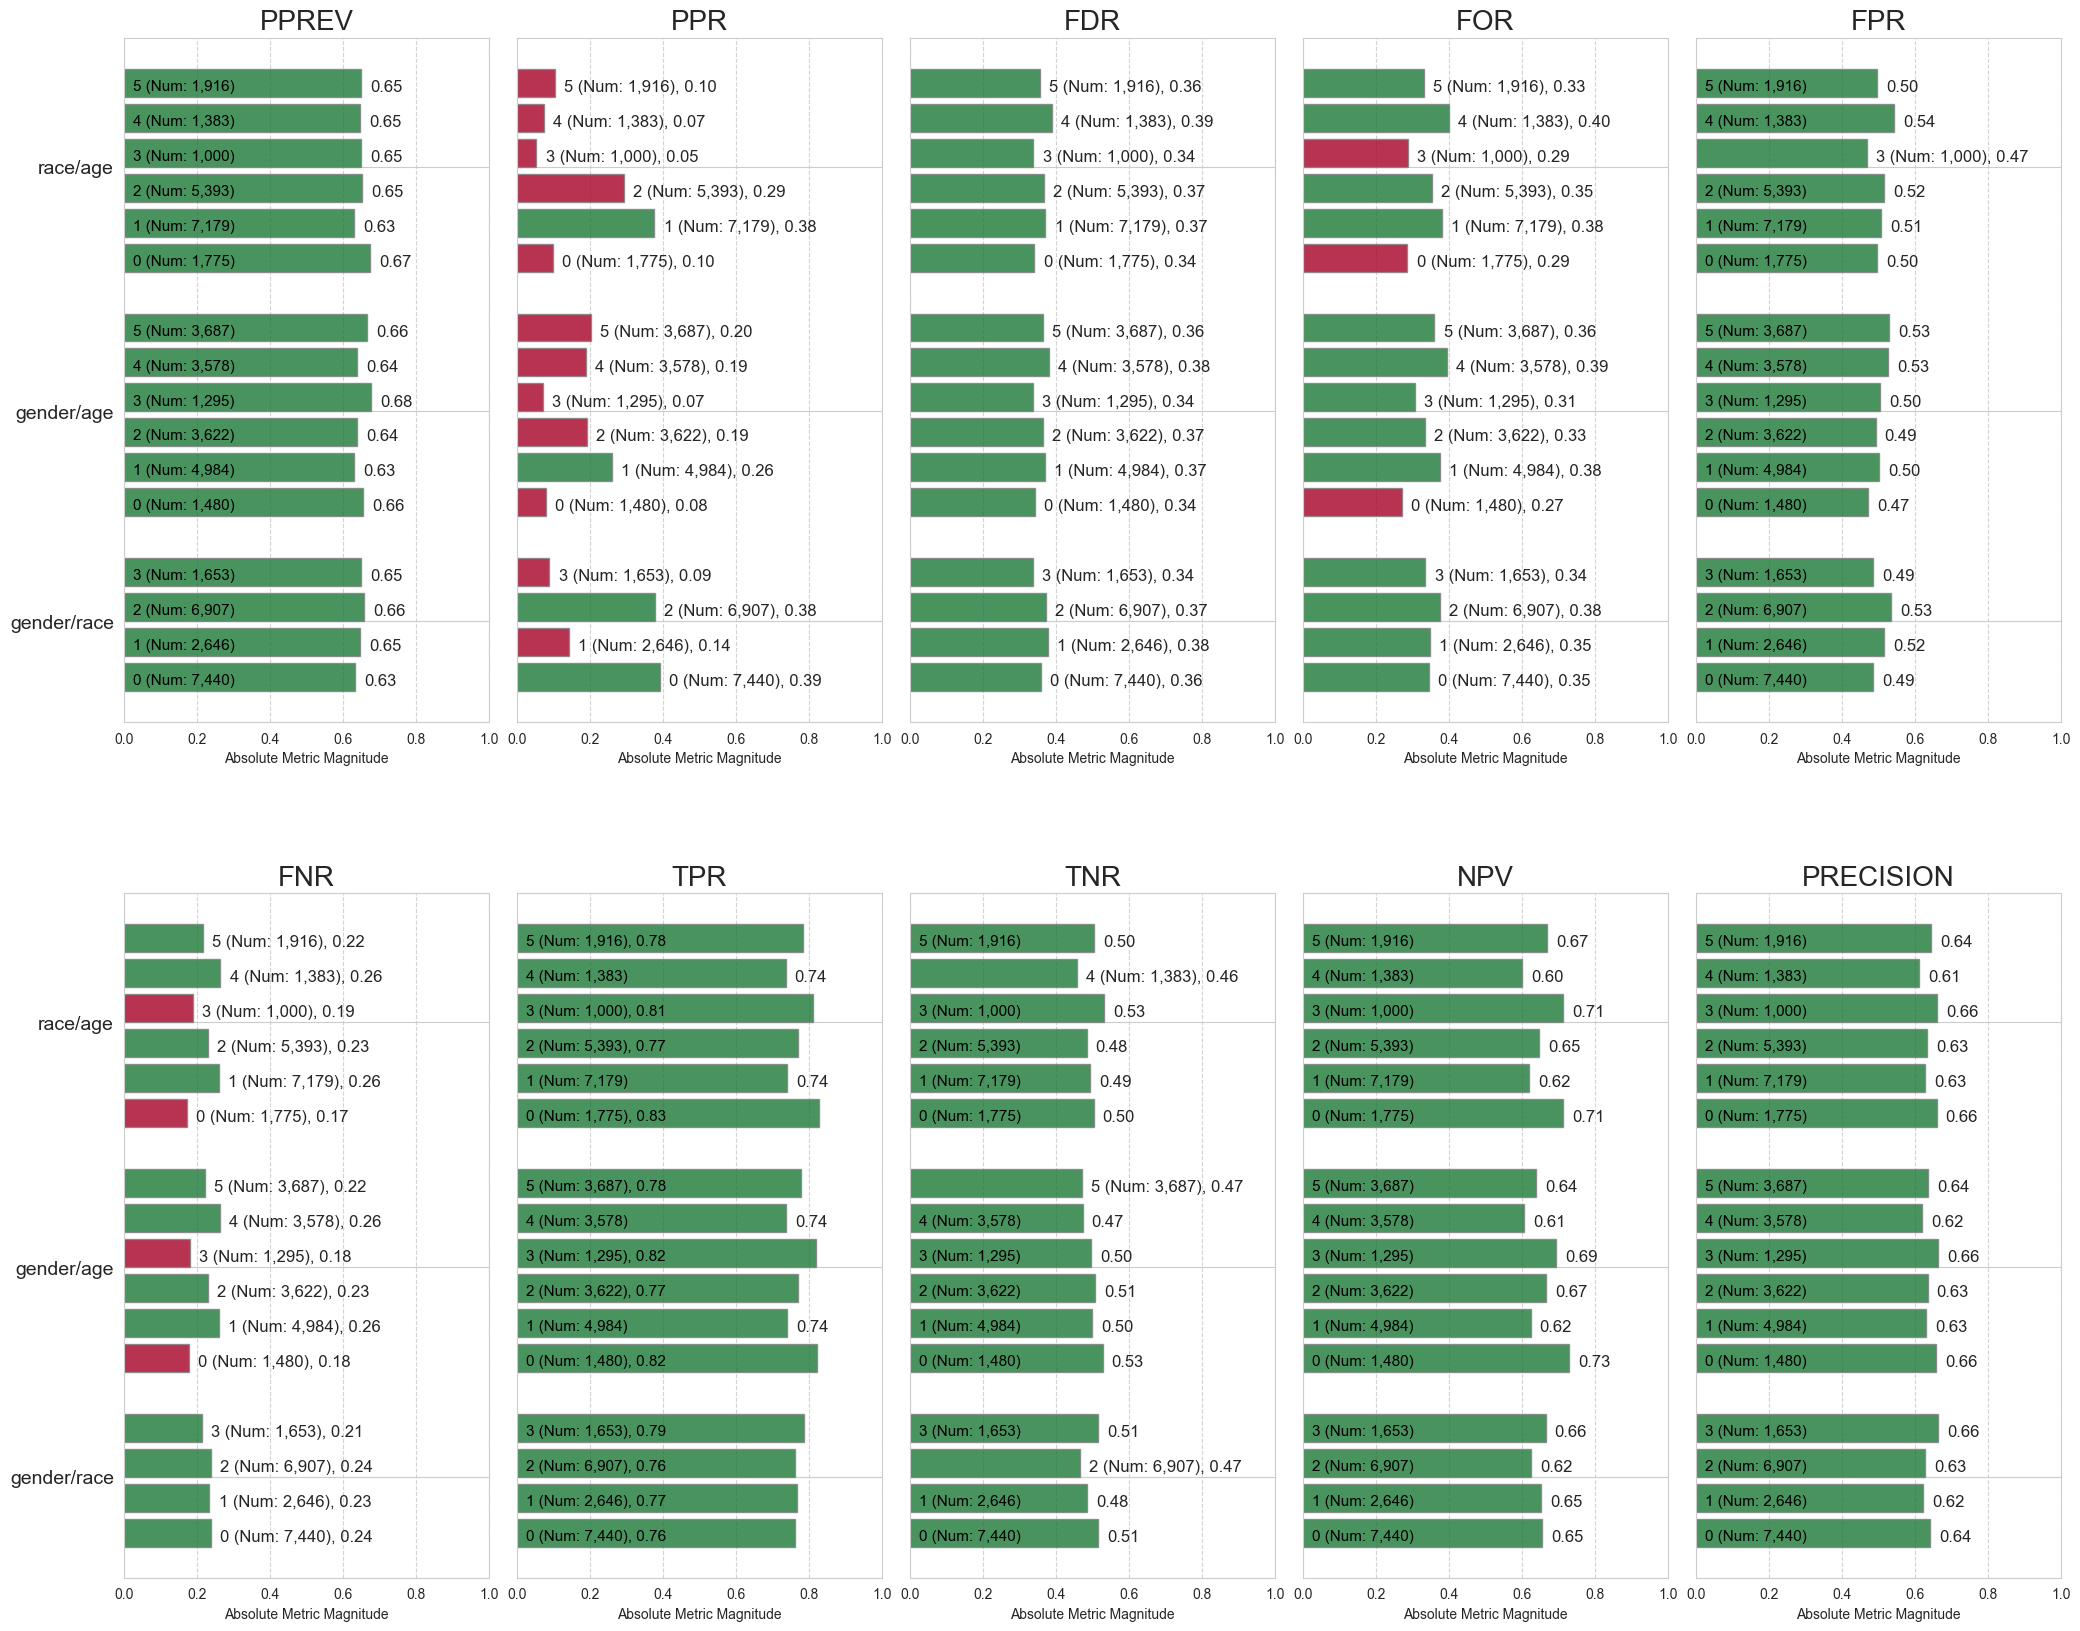

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1     gender/age               False           True   
1         0      binary 0/1    gender/race               False           True   
2         0      binary 0/1       race/age               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0        True        True       False       False        True        True   
1        True        True        True        True        True        True   
2        True        True       False       False        True        True   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0        True              True          True          False            True   
1        True              True          True           True            True   
2        True              True          True          False            True   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                 True  
2                  False                False

alt.VConcatChart(...)

alt.VConcatChart(...)

<Figure size 640x480 with 0 Axes>

In [11]:
''' 
2: Prevalance Sampling: Generates a training sample with controllable balanced prevalence for the groups in dataset, either by undersampling or oversampling.
'''
#transform data
data_to_transform = df_num_int.copy()
data_transformed_ps = prep_prev_sampling(data_to_transform, protected_attributes_int, target)
#train the new dataset
x_test_ps, y_test_ps, y_predicted_dict_ps, metrics_ps_dict = split_and_train(data_transformed_ps,protected_attributes_int,target)
df_test_transformed_ps =calc_fairness_report(x_test_ps, y_test_ps, y_predicted_dict_ps["Catboost"],target,protected_attributes_int,list_of_disparities, priv,display_disp=True)

#compare disparities
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed_ps, protected_attributes_int)

---------- Model name:  Catboost ----------

Accuracy score training:
0.6327
Accuracy score test:
0.6330
----------------------------------------

Classification report for model: <catboost.core.CatBoostClassifier object at 0x000002B0E49DA230> : 
               precision    recall  f1-score   support

           0       0.64      0.48      0.55      9124
           1       0.63      0.76      0.69     10487

    accuracy                           0.63     19611
   macro avg       0.63      0.62      0.62     19611
weighted avg       0.63      0.63      0.63     19611



attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0     gender/race               0      0.63  0.74  0.51  0.36  0.37  0.49   
1     gender/race               1      0.64  0.79  0.46  0.35  0.36  0.54   
2     gender/race               2      0.63  0.78  0.46  0.36  0.38  0.54   
3     gender/race               3      0.65  0.78  0.49  0.35  0.35  0.51   
4      gender/age               0      0.69  0.82  0.51  0.31  0.31  0.49   
5      gender/age               1      0.61  0.71  0.49  0.38  0.40  0.51   
6      gender/age               2      0.65  0.77  0.51  0.34  0.36  0.49   
7      gender/age               3      0.67  0.81  0.51  0.31  0.34  0.49   
8      gender/age               4      0.61  0.74  0.47  0.38  0.39  0.53   
9      gender/age               5      0.64  0.80  0.45  0.36  0.36  0.55   
10       race/age               0      0.68  0.81  0.51  0.31  0.33  0.49   
11       race/age               1      0.61  0.72  0.49  0.38  0.40  0.51   
12       race/age               2      0.64  0.78  0.47  0.35  0.36  0.53   
13       race/age               3      0.68  0.81  0.51  0.31  0.32  0.49   
14       race/age               4      0.60  0.75  0.42  0.41  0.40  0.58   
15       race/age               5      0.66  0.80  0.48  0.33  0.35  0.52   

     fnr   npv  precision   ppr  pprev  prev  
0   0.26  0.64       0.63  0.38   0.62  0.52  
1   0.21  0.65       0.64  0.15   0.68  0.55  
2   0.22  0.64       0.62  0.38   0.67  0.54  
3   0.22  0.65       0.65  0.10   0.66  0.55  
4   0.18  0.69       0.69  0.08   0.68  0.57  
5   0.29  0.62       0.60  0.25   0.61  0.52  
6   0.23  0.66       0.64  0.19   0.64  0.53  
7   0.19  0.69       0.66  0.07   0.66  0.54  
8   0.26  0.62       0.61  0.19   0.64  0.53  
9   0.20  0.64       0.64  0.21   0.69  0.55  
10  0.19  0.69       0.67  0.10   0.67  0.55  
11  0.28  0.62       0.60  0.36   0.62  0.52  
12  0.22  0.65       0.64  0.30   0.66  0.54  
13  0.19  0.69       0.68  0.06   0.67  0.56  
14  0.25  0.59       0.60  0.08   0.67  0.54  
15  0.20  0.67       0.65  0.11   0.67  0.55

Majority class for:  gender/race  is: 0
Majority class for:  gender/age  is: 1
Majority class for:  race/age  is: 1
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0     gender/race               0           1.00           1.00   
1     gender/race               1           0.97           0.80   
2     gender/race               2           1.01           0.86   
3     gender/race               3           0.93           0.83   
4      gender/age               0           0.78           0.63   
5      gender/age               1           1.00           1.00   
6      gender/age               2           0.90           0.79   
7      gender/age               3           0.86           0.67   
8      gender/age               4           0.99           0.91   
9      gender/age               5           0.90           0.70   
10       race/age               0           0.83           0.66   
11       race/age               1           1.00           1.00   
12       race/age               2           0.92           0.78   
13       race/age               3           0.81           0.67   
14       race/age               4           1.00           0.90   
15       race/age               5           0.88           0.71   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.00           1.00           1.00           1.00   
1            0.98           1.11           1.01           0.38   
2            1.01           1.12           0.99           0.99   
3            0.98           1.05           1.01           0.25   
4            0.82           0.96           1.11           0.32   
5            1.00           1.00           1.00           1.00   
6            0.88           0.97           1.07           0.75   
7            0.81           0.97           1.12           0.28   
8            1.00           1.05           1.00           0.73   
9            0.93           1.09           1.04           0.84   
10           0.82           0.97           1.11           0.26   
11           1.00           1.00           1.00           1.00   
12           0.93           1.04           1.04           0.82   
13           0.83           0.96           1.11           0.16   
14           1.09           1.14           0.95           0.21   
15           0.88           1.02           1.08           0.29   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              1.00                 1.00           1.00           1.00  
1              1.09                 1.02           0.90           1.07  
2              1.08                 1.00           0.89           1.05  
3              1.07                 1.04           0.95           1.06  
4              1.10                 1.14           1.04           1.15  
5              1.00                 1.00           1.00           1.00  
6              1.05                 1.07           1.03           1.08  
7              1.08                 1.10           1.03           1.13  
8              1.05                 1.01           0.95           1.04  
9              1.12                 1.06           0.91           1.12  
10             1.09                 1.11           1.03           1.13  
11             1.00                 1.00           1.00           1.00  
12             1.08                 1.05           0.96           1.09  
13             1.08                 1.12           1.04           1.13  
14             1.09                 1.00           0.86           1.04  
15             1.09                 1.08           0.98           1.11

             fnr_disparity
gender/age           0.740
gender/race          0.830
race/age             0.744
Overall average for fnr_disparity:  0.771


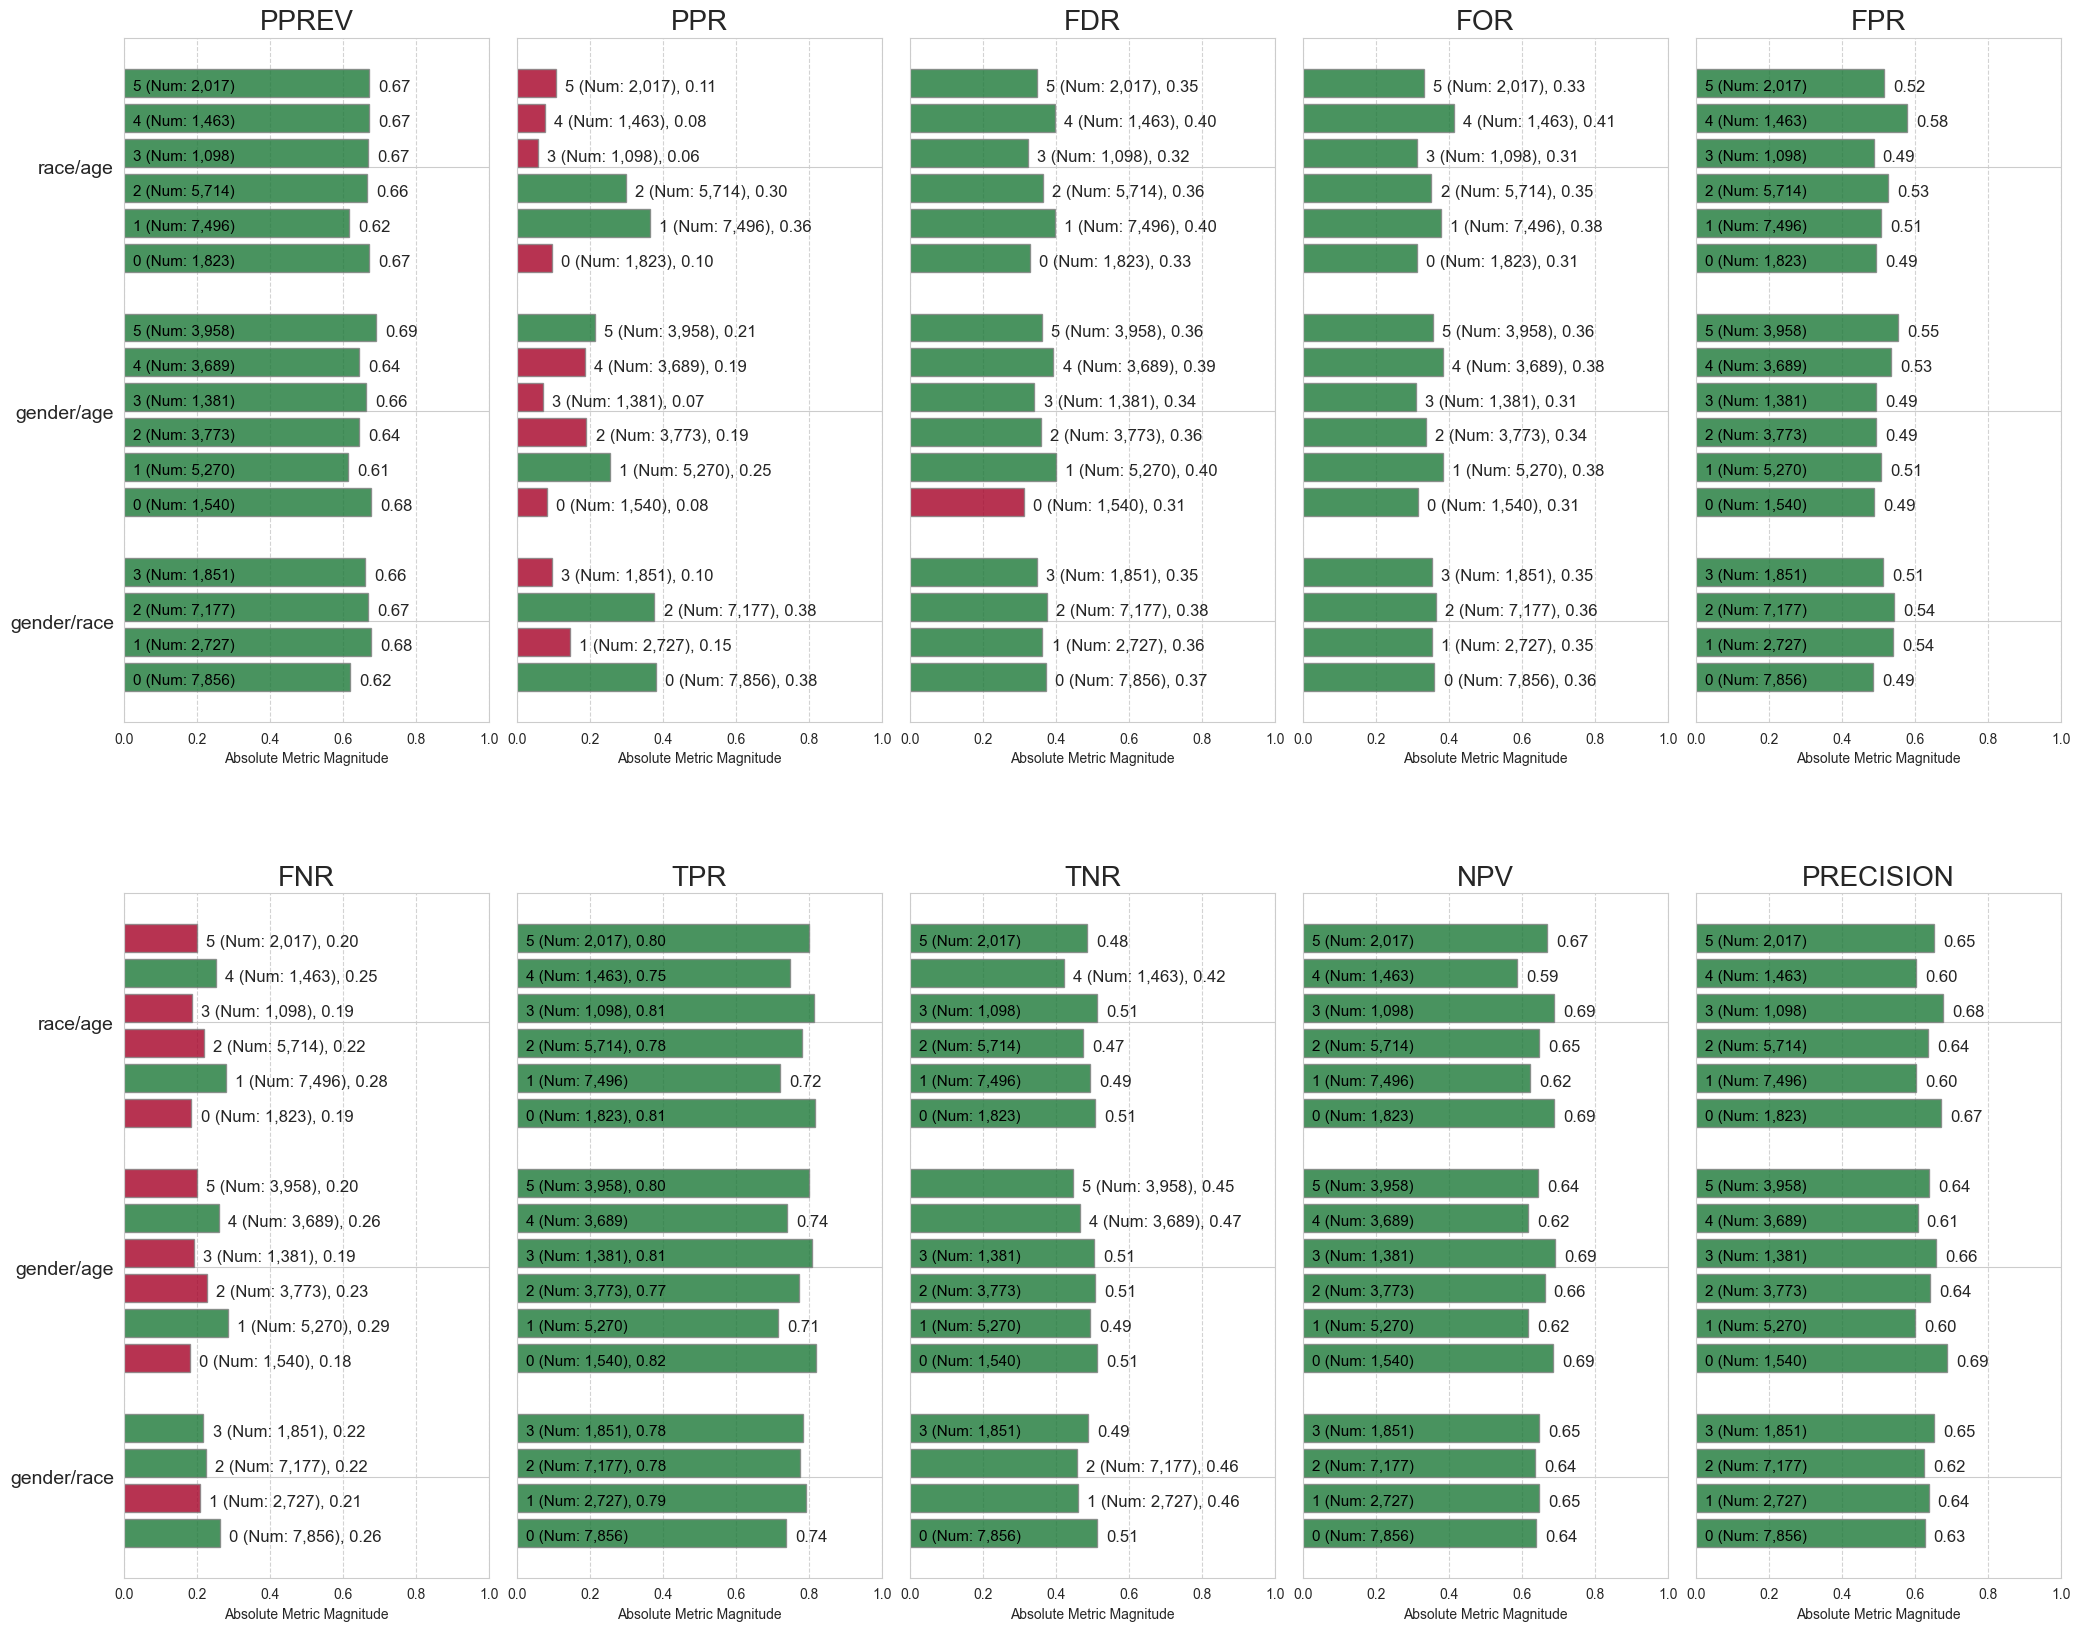

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1     gender/age               False           True   
1         0      binary 0/1    gender/race               False           True   
2         0      binary 0/1       race/age               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False        True        True       False        True        True   
1        True        True        True       False        True        True   
2        True        True        True       False        True        True   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0        True              True         False          False            True   
1        True              True          True          False            True   
2        True              True          True          False            True   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                False  
2                  False                False

alt.VConcatChart(...)

alt.VConcatChart(...)

<Figure size 640x480 with 0 Axes>

In [12]:
'''
3. Data repairer: Transforms the data distribution so that a given feature distribution is marginally independent of the sensitive attribute, s. 
'''

#transform data
data_to_transform = df_num_int.copy()
data_transformed_dr=prep_data_repairer(df_num_int,protected_attributes_int,target)

#train
x_test_dr, y_test_dr, y_predicted_dict_dr, metrics_dr_dict = split_and_train(data_transformed_dr,
                                                                             protected_attributes_int,target)

#calc metrics
df_test_transformed_dr = calc_fairness_report(x_test_dr, y_test_dr, y_predicted_dict_dr["Catboost"], target,
                                              protected_attributes_int,list_of_disparities, priv,display_disp=True)

#compare disparities
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed_dr, protected_attributes_int)

[INFO] 2024-11-20 20:56:26 methods.preprocessing.LabelFlipping - Instantiating a LabelFlipping preprocessing method.


INFO:methods.preprocessing.LabelFlipping:Instantiating a LabelFlipping preprocessing method.


[INFO] 2024-11-20 20:56:26 methods.preprocessing.LabelFlipping - Fitting LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Fitting LabelFlipping.


[INFO] 2024-11-20 20:56:30 methods.preprocessing.LabelFlipping - Transforming data with LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Transforming data with LabelFlipping.


[INFO] 2024-11-20 20:56:31 methods.preprocessing.LabelFlipping - Flipped 2616 instances.


INFO:methods.preprocessing.LabelFlipping:Flipped 2616 instances.


[INFO] 2024-11-20 20:56:31 methods.preprocessing.LabelFlipping - Data transformed.


INFO:methods.preprocessing.LabelFlipping:Data transformed.


[INFO] 2024-11-20 20:56:31 methods.preprocessing.LabelFlipping - Instantiating a LabelFlipping preprocessing method.


INFO:methods.preprocessing.LabelFlipping:Instantiating a LabelFlipping preprocessing method.


[INFO] 2024-11-20 20:56:31 methods.preprocessing.LabelFlipping - Fitting LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Fitting LabelFlipping.


[INFO] 2024-11-20 20:56:35 methods.preprocessing.LabelFlipping - Transforming data with LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Transforming data with LabelFlipping.


[INFO] 2024-11-20 20:56:36 methods.preprocessing.LabelFlipping - Flipped 2745 instances.


INFO:methods.preprocessing.LabelFlipping:Flipped 2745 instances.


[INFO] 2024-11-20 20:56:36 methods.preprocessing.LabelFlipping - Data transformed.


INFO:methods.preprocessing.LabelFlipping:Data transformed.


[INFO] 2024-11-20 20:56:36 methods.preprocessing.LabelFlipping - Instantiating a LabelFlipping preprocessing method.


INFO:methods.preprocessing.LabelFlipping:Instantiating a LabelFlipping preprocessing method.


[INFO] 2024-11-20 20:56:36 methods.preprocessing.LabelFlipping - Fitting LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Fitting LabelFlipping.


[INFO] 2024-11-20 20:56:40 methods.preprocessing.LabelFlipping - Transforming data with LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Transforming data with LabelFlipping.


[INFO] 2024-11-20 20:56:40 methods.preprocessing.LabelFlipping - Flipped 2881 instances.


INFO:methods.preprocessing.LabelFlipping:Flipped 2881 instances.


[INFO] 2024-11-20 20:56:40 methods.preprocessing.LabelFlipping - Data transformed.


INFO:methods.preprocessing.LabelFlipping:Data transformed.


---------- Model name:  Catboost ----------

Accuracy score training:
0.6967
Accuracy score test:
0.6933
----------------------------------------

Classification report for model: <catboost.core.CatBoostClassifier object at 0x000002B0ED88D870> : 
               precision    recall  f1-score   support

           0       0.65      0.42      0.51      7506
           1       0.71      0.86      0.78     12105

    accuracy                           0.69     19611
   macro avg       0.68      0.64      0.64     19611
weighted avg       0.69      0.69      0.68     19611



attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0     gender/race               0      0.69  0.85  0.43  0.35  0.29  0.57   
1     gender/race               1      0.70  0.87  0.43  0.33  0.29  0.57   
2     gender/race               2      0.69  0.87  0.40  0.35  0.30  0.60   
3     gender/race               3      0.70  0.86  0.46  0.33  0.28  0.54   
4      gender/age               0      0.73  0.88  0.48  0.31  0.26  0.52   
5      gender/age               1      0.68  0.85  0.40  0.38  0.31  0.60   
6      gender/age               2      0.71  0.86  0.45  0.32  0.29  0.55   
7      gender/age               3      0.72  0.89  0.47  0.27  0.28  0.53   
8      gender/age               4      0.68  0.85  0.40  0.39  0.30  0.60   
9      gender/age               5      0.70  0.87  0.41  0.33  0.29  0.59   
10       race/age               0      0.73  0.89  0.46  0.28  0.27  0.54   
11       race/age               1      0.68  0.85  0.41  0.38  0.30  0.59   
12       race/age               2      0.70  0.87  0.42  0.33  0.29  0.58   
13       race/age               3      0.72  0.86  0.50  0.29  0.27  0.50   
14       race/age               4      0.67  0.85  0.38  0.40  0.31  0.62   
15       race/age               5      0.71  0.87  0.46  0.31  0.28  0.54   

     fnr   npv  precision   ppr  pprev  prev  
0   0.15  0.65       0.71  0.40   0.74  0.62  
1   0.13  0.67       0.71  0.14   0.75  0.62  
2   0.13  0.65       0.70  0.37   0.76  0.62  
3   0.14  0.67       0.72  0.09   0.73  0.61  
4   0.12  0.69       0.74  0.08   0.75  0.63  
5   0.15  0.62       0.69  0.27   0.75  0.61  
6   0.14  0.68       0.71  0.19   0.74  0.61  
7   0.11  0.73       0.72  0.07   0.75  0.60  
8   0.15  0.61       0.70  0.19   0.75  0.62  
9   0.13  0.67       0.71  0.21   0.77  0.62  
10  0.11  0.72       0.73  0.09   0.76  0.63  
11  0.15  0.62       0.70  0.38   0.75  0.62  
12  0.13  0.67       0.71  0.29   0.76  0.62  
13  0.14  0.71       0.73  0.05   0.72  0.61  
14  0.15  0.60       0.69  0.08   0.77  0.63  
15  0.13  0.69       0.72  0.10   0.74  0.61

Majority class for:  gender/race  is: 0
Majority class for:  gender/age  is: 1
Majority class for:  race/age  is: 1
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0     gender/race               0           1.00           1.00   
1     gender/race               1           0.99           0.91   
2     gender/race               2           1.02           0.91   
3     gender/race               3           0.97           0.99   
4      gender/age               0           0.84           0.79   
5      gender/age               1           1.00           1.00   
6      gender/age               2           0.93           0.88   
7      gender/age               3           0.92           0.73   
8      gender/age               4           0.99           1.00   
9      gender/age               5           0.96           0.82   
10       race/age               0           0.88           0.70   
11       race/age               1           1.00           1.00   
12       race/age               2           0.96           0.85   
13       race/age               3           0.90           0.87   
14       race/age               4           1.00           0.97   
15       race/age               5           0.92           0.84   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.00           1.00           1.00           1.00   
1            0.94           1.01           1.03           0.35   
2            0.99           1.05           1.00           0.94   
3            0.94           0.95           1.03           0.23   
4            0.81           0.87           1.12           0.29   
5            1.00           1.00           1.00           1.00   
6            0.85           0.92           1.09           0.71   
7            0.71           0.89           1.18           0.26   
8            1.03           1.01           0.98           0.70   
9            0.88           0.99           1.08           0.77   
10           0.75           0.92           1.15           0.25   
11           1.00           1.00           1.00           1.00   
12           0.88           0.97           1.08           0.77   
13           0.77           0.84           1.14           0.14   
14           1.05           1.05           0.97           0.20   
15           0.82           0.91           1.11           0.27   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              1.00                 1.00           1.00           1.00  
1              1.01                 1.00           0.99           1.02  
2              1.03                 0.99           0.93           1.01  
3              0.98                 1.01           1.07           1.00  
4              1.00                 1.07           1.19           1.04  
5              1.00                 1.00           1.00           1.00  
6              0.99                 1.03           1.12           1.02  
7              1.00                 1.03           1.16           1.05  
8              1.01                 1.01           0.98           1.00  
9              1.02                 1.02           1.02           1.03  
10             1.02                 1.05           1.12           1.06  
11             1.00                 1.00           1.00           1.00  
12             1.01                 1.02           1.04           1.03  
13             0.96                 1.05           1.23           1.02  
14             1.02                 1.00           0.93           1.01  
15             0.99                 1.03           1.13           1.03

             fnr_disparity
gender/age        0.844000
gender/race       0.936667
race/age          0.846000
Overall average for fnr_disparity:  0.876


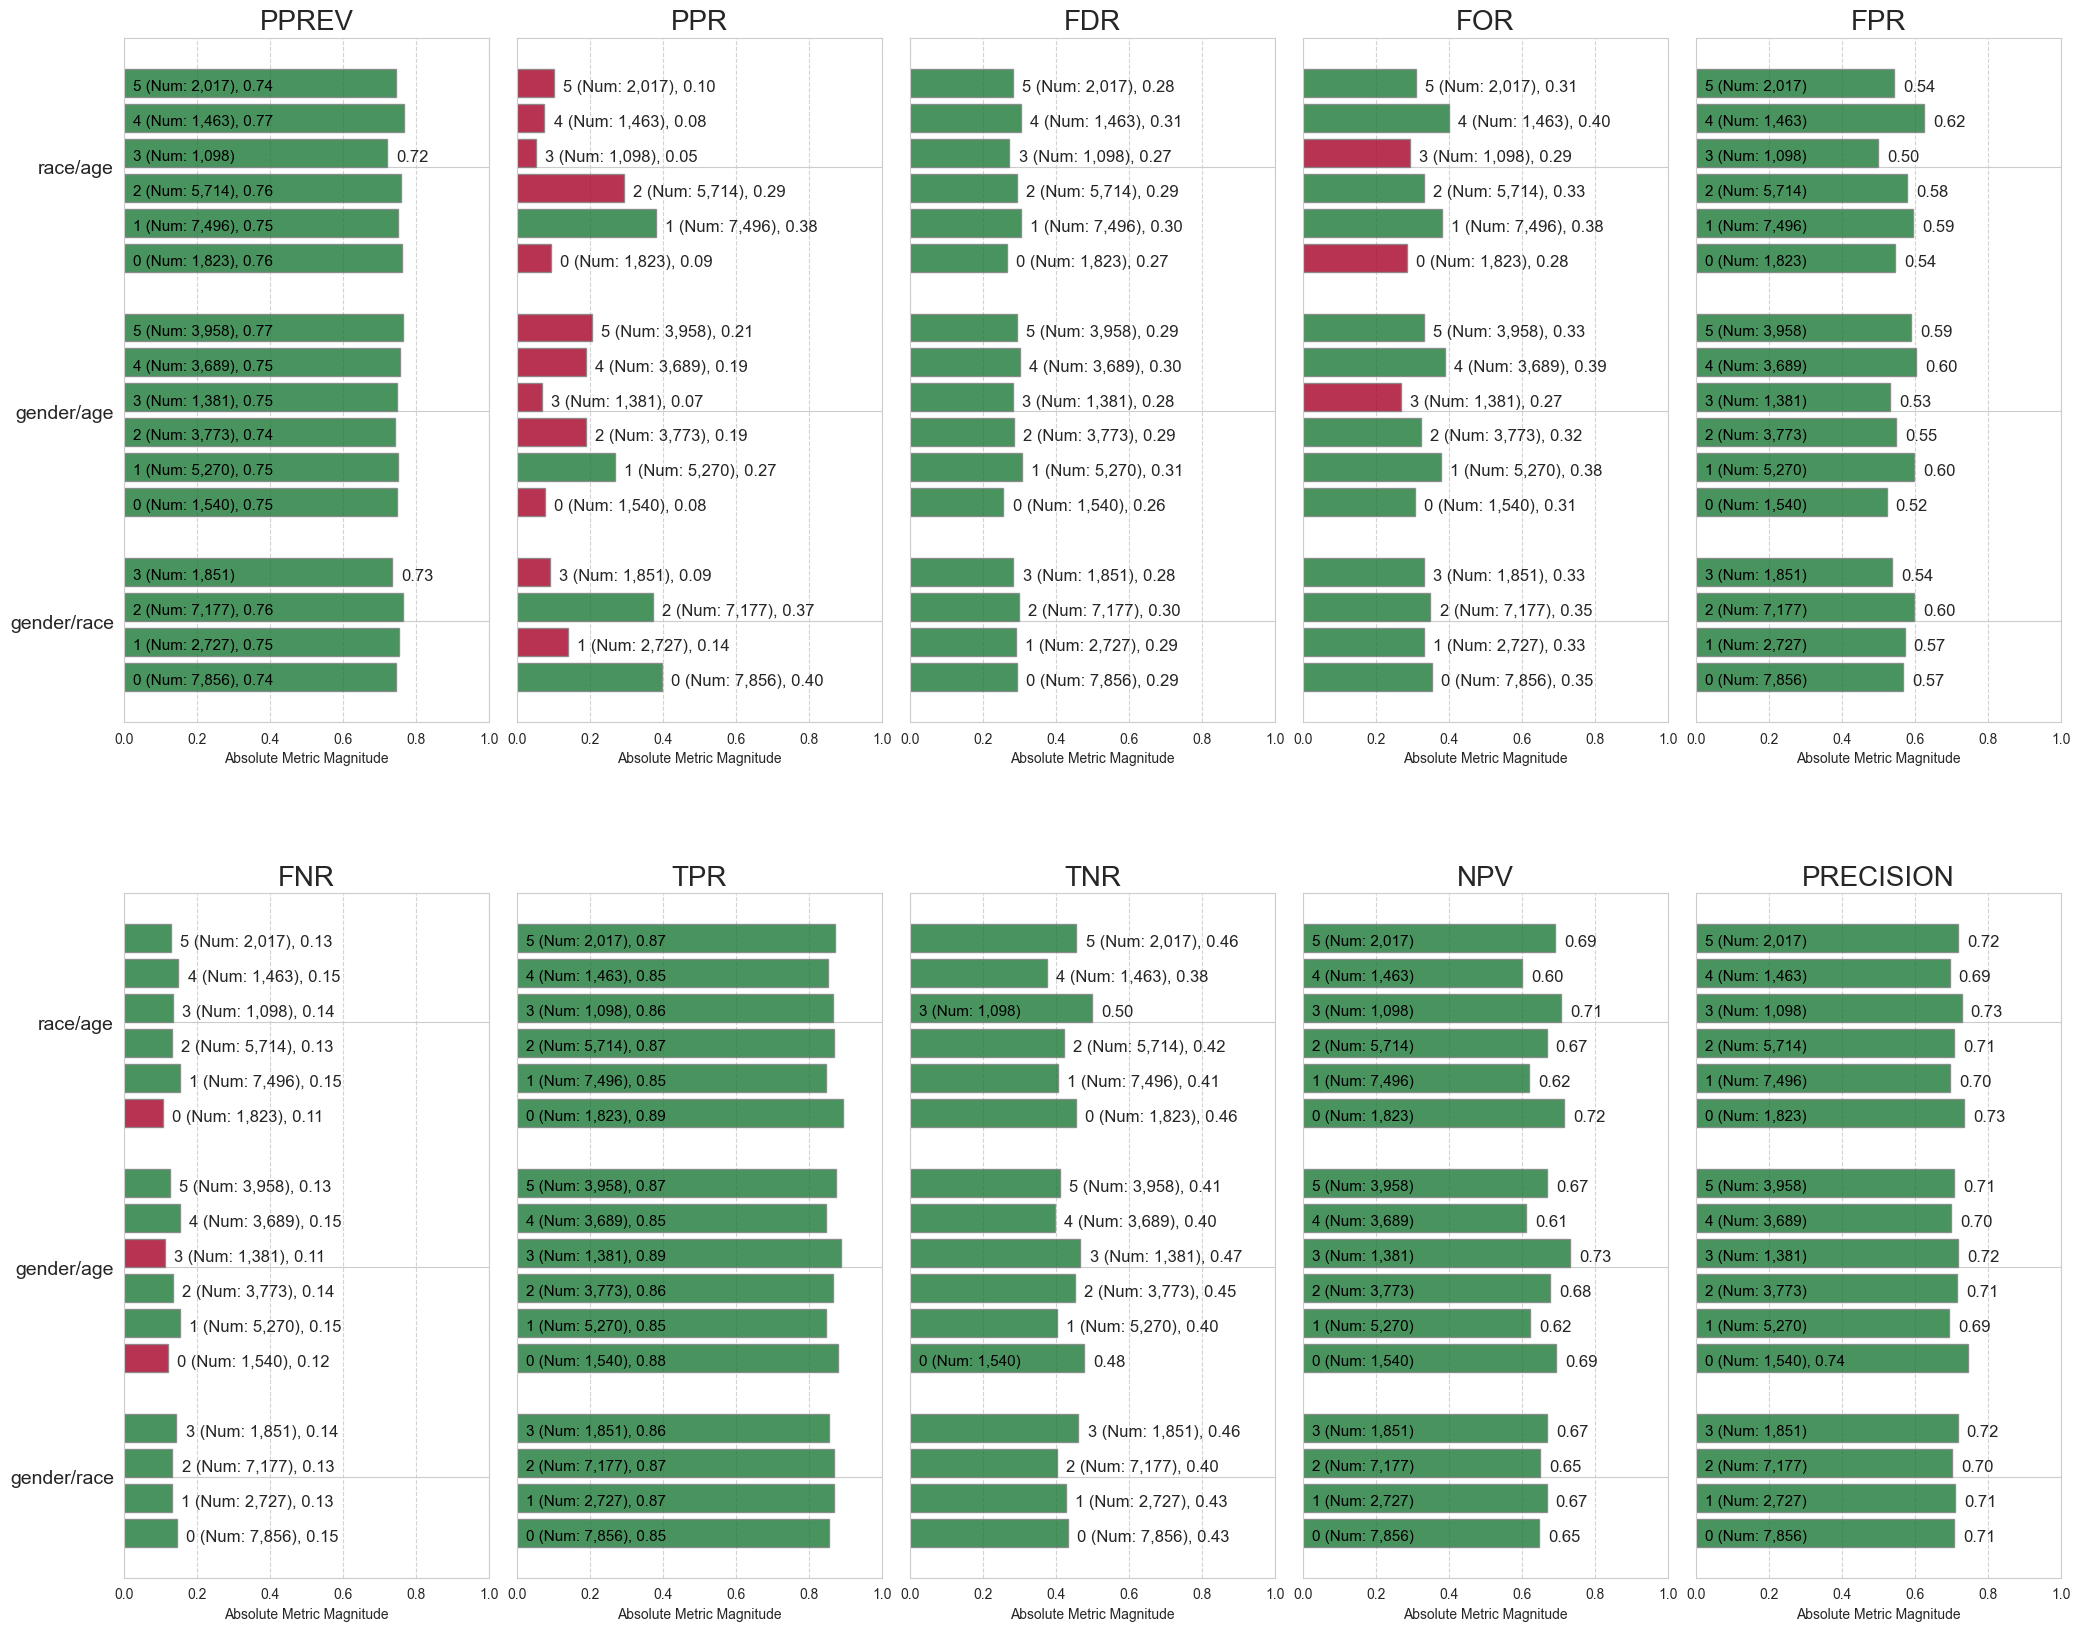

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1     gender/age               False           True   
1         0      binary 0/1    gender/race               False           True   
2         0      binary 0/1       race/age               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0        True        True       False       False        True        True   
1        True        True        True        True        True        True   
2        True        True       False       False        True        True   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0        True              True          True          False            True   
1        True              True          True           True            True   
2        True              True          True          False            True   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                 True  
2                  False                False

<Figure size 640x480 with 0 Axes>

In [16]:
'''
4. Label flipping
'''
gc.collect()
#transform data
data_to_transform = df_num_int.copy()
data_transformed_lr = prep_label_flipping(df_num_int,protected_attributes_int,target)

#train
x_test_lf, y_test_lf, y_predicted_dict_lf, metrics_lf_dict = split_and_train(data_transformed_lr,
                                                                             protected_attributes_int,target)

#calc metrics
df_test_transformed_lf =calc_fairness_report(x_test_lf, y_test_lf, y_predicted_dict_lf["Catboost"], target,
                                              protected_attributes_int,list_of_disparities, priv,display_disp=True)

#compare disparities
# plot_audit(df_test_int, protected_attributes_int)
# plot_audit(df_test_transformed_lf, protected_attributes_int)

In [ ]:
from aequitas.flow.methods.inprocessing import FairlearnClassifier

'''
In-processing: Fair learn classifier 
'''

data_to_transform = df_num_int.copy()
models = ["sklearn.ensemble.RandomForestClassifier"]
metrics_dict = {}
for attr in protected_attributes_int:
    x_test_fl, y_test_fl, y_test_pred_fl, metrics_dict_fl = train_with_fairlearn(data_to_transform, attr,
                                                                                 models[0], metrics_dict, target)
    df_test_transformed_fl =calc_fairness_report(x_test_fl, y_test_fl, y_test_pred_fl,target,protected_attributes_int, list_of_disparities, priv, display_disp=True)


[INFO] 2024-11-20 21:08:23 methods.inprocessing.ExponentiatedGradient - Instantiating estimator '<class 'sklearn.ensemble._forest.RandomForestClassifier'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating estimator '<class 'sklearn.ensemble._forest.RandomForestClassifier'>' with parameters: {}.


[INFO] 2024-11-20 21:08:23 methods.inprocessing.ExponentiatedGradient - Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.EqualizedOdds'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.EqualizedOdds'>' with parameters: {}.


[INFO] 2024-11-20 21:08:23 methods.inprocessing.ExponentiatedGradient - Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


Accuracy score test:
0.6123


attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0     gender/race             0.0      0.61  0.75  0.44  0.38  0.40  0.56   
1     gender/race             1.0      0.59  0.83  0.33  0.37  0.42  0.67   
2     gender/race             2.0      0.62  0.82  0.39  0.35  0.39  0.61   
3     gender/race             3.0      0.64  0.86  0.35  0.34  0.37  0.65   
4      gender/age             0.0      0.65  0.85  0.42  0.30  0.37  0.58   
5      gender/age             1.0      0.57  0.73  0.40  0.42  0.43  0.60   
6      gender/age             2.0      0.62  0.79  0.43  0.34  0.39  0.57   
7      gender/age             3.0      0.66  0.90  0.36  0.26  0.37  0.64   
8      gender/age             4.0      0.59  0.79  0.36  0.38  0.42  0.64   
9      gender/age             5.0      0.65  0.84  0.40  0.33  0.36  0.60   
10       race/age             0.0      0.65  0.86  0.40  0.30  0.37  0.60   
11       race/age             1.0      0.58  0.75  0.41  0.40  0.42  0.59   
12       race/age             2.0      0.64  0.81  0.43  0.33  0.38  0.57   
13       race/age             3.0      0.66  0.89  0.37  0.27  0.37  0.63   
14       race/age             4.0      0.56  0.81  0.27  0.43  0.45  0.73   
15       race/age             5.0      0.63  0.84  0.37  0.35  0.38  0.63   

     fnr   npv  precision   ppr  pprev  prev  
0   0.25  0.62       0.60  0.37   0.66  0.53  
1   0.17  0.63       0.58  0.15   0.75  0.53  
2   0.18  0.65       0.61  0.38   0.73  0.54  
3   0.14  0.66       0.63  0.11   0.77  0.57  
4   0.15  0.70       0.63  0.08   0.73  0.54  
5   0.27  0.58       0.57  0.25   0.67  0.52  
6   0.21  0.66       0.61  0.18   0.69  0.52  
7   0.10  0.74       0.63  0.08   0.78  0.55  
8   0.21  0.62       0.58  0.20   0.72  0.52  
9   0.16  0.67       0.64  0.21   0.74  0.56  
10  0.14  0.70       0.63  0.10   0.74  0.55  
11  0.25  0.60       0.58  0.37   0.67  0.52  
12  0.19  0.67       0.62  0.28   0.70  0.54  
13  0.11  0.73       0.63  0.06   0.78  0.55  
14  0.19  0.57       0.55  0.08   0.77  0.53  
15  0.16  0.65       0.62  0.11   0.74  0.55

Majority class for:  gender/race  is: 0.0
Majority class for:  gender/age  is: 1.0
Majority class for:  race/age  is: 1.0
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0     gender/race             0.0           1.00           1.00   
1     gender/race             1.0           1.05           0.70   
2     gender/race             2.0           0.98           0.72   
3     gender/race             3.0           0.91           0.55   
4      gender/age             0.0           0.85           0.56   
5      gender/age             1.0           1.00           1.00   
6      gender/age             2.0           0.92           0.77   
7      gender/age             3.0           0.85           0.39   
8      gender/age             4.0           0.98           0.77   
9      gender/age             5.0           0.84           0.59   
10       race/age             0.0           0.87           0.56   
11       race/age             1.0           1.00           1.00   
12       race/age             2.0           0.89           0.74   
13       race/age             3.0           0.87           0.43   
14       race/age             4.0           1.06           0.75   
15       race/age             5.0           0.90           0.64   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.00           1.00           1.00           1.00   
1            0.97           1.20           1.02           0.40   
2            0.91           1.10           1.06           1.02   
3            0.88           1.16           1.08           0.29   
4            0.71           0.97           1.21           0.33   
5            1.00           1.00           1.00           1.00   
6            0.81           0.94           1.14           0.74   
7            0.62           1.06           1.28           0.31   
8            0.90           1.05           1.07           0.80   
9            0.78           1.00           1.16           0.82   
10           0.73           1.00           1.18           0.26   
11           1.00           1.00           1.00           1.00   
12           0.83           0.96           1.12           0.76   
13           0.66           1.07           1.23           0.17   
14           1.07           1.22           0.95           0.23   
15           0.86           1.06           1.09           0.30   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              1.00                 1.00           1.00           1.00  
1              1.14                 0.97           0.75           1.10  
2              1.10                 1.02           0.87           1.09  
3              1.17                 1.06           0.79           1.15  
4              1.09                 1.11           1.05           1.16  
5              1.00                 1.00           1.00           1.00  
6              1.02                 1.06           1.08           1.08  
7              1.17                 1.11           0.90           1.22  
8              1.07                 1.01           0.92           1.08  
9              1.10                 1.12           1.01           1.15  
10             1.10                 1.10           1.00           1.15  
11             1.00                 1.00           1.00           1.00  
12             1.04                 1.08           1.07           1.09  
13             1.15                 1.10           0.90           1.19  
14             1.14                 0.96           0.67           1.09  
15             1.10                 1.07           0.92           1.12

             fnr_disparity
gender/age        0.680000
gender/race       0.742500
race/age          0.686667
Overall average for fnr_disparity:  0.703


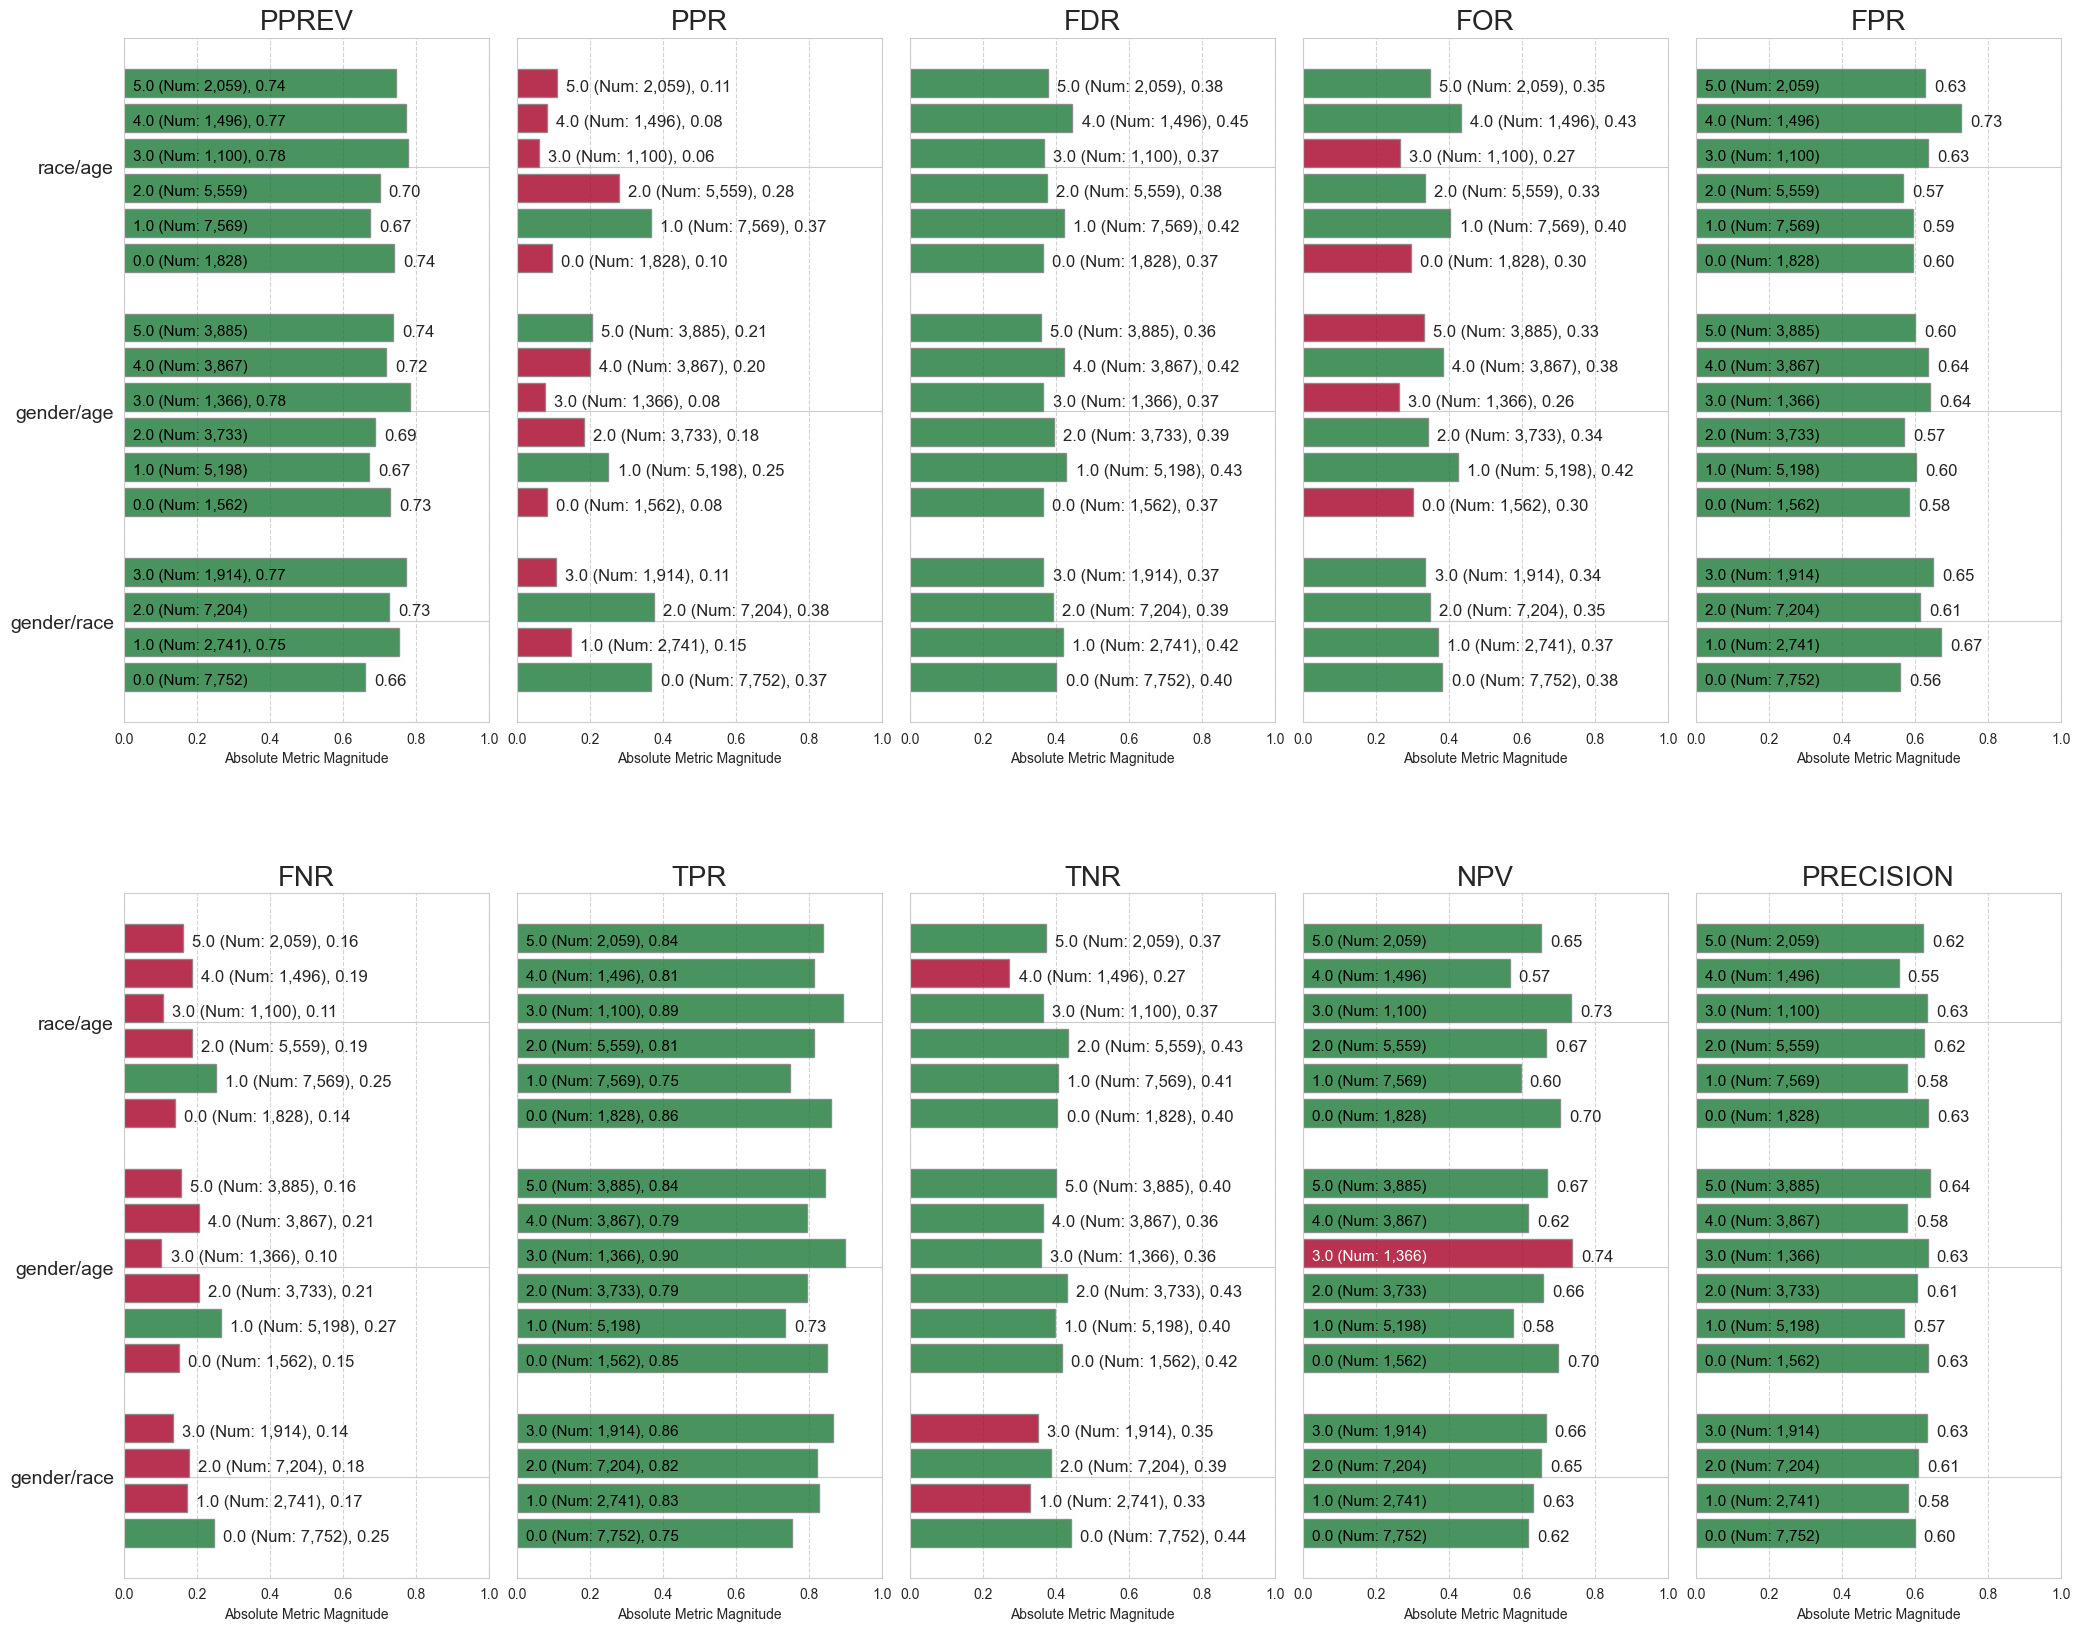

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1     gender/age               False           True   
1         0      binary 0/1    gender/race               False           True   
2         0      binary 0/1       race/age               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0        True        True       False       False        True        True   
1        True        True        True       False        True       False   
2        True        True       False       False        True       False   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0       False              True          True          False            True   
1        True              True          True          False            True   
2        True              True          True          False            True   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                False  
2                  False                False

<Figure size 640x480 with 0 Axes>

In [13]:
"""Gerry fair"""""

maj_1 = get_majority_classes(df_num_int["gender/race"])[0]
maj_2 = get_majority_classes(df_num_int["gender/age"])[0]
maj_3 = get_majority_classes(df_num_int["race/age"])[0]
maj_classes = [[maj_1],[maj_2],[maj_3]]

x_test_gf,y_test_gf,y_test_pred_gf = in_process_gerryfair(df_num_int,target, protected_attributes_int, maj_classes, len(df_num_int)-len(x_test_int))
df_test_transformed_gf =calc_fairness_report(x_test_gf, y_test_gf, y_test_pred_gf,target,protected_attributes_int, list_of_disparities, priv, display_disp=True)

---------- Model name:  Catboost ----------

Accuracy score test corrected:
0.6337


attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0     gender/race               0      0.63  0.65  0.62  0.39  0.35  0.38   
1     gender/race               1      0.64  0.64  0.63  0.41  0.32  0.37   
2     gender/race               2      0.63  0.65  0.61  0.40  0.34  0.39   
3     gender/race               3      0.65  0.65  0.65  0.40  0.31  0.35   
4      gender/age               0      0.67  0.64  0.72  0.40  0.25  0.28   
5      gender/age               1      0.61  0.65  0.57  0.40  0.38  0.43   
6      gender/age               2      0.65  0.65  0.65  0.38  0.32  0.35   
7      gender/age               3      0.67  0.67  0.68  0.37  0.29  0.32   
8      gender/age               4      0.62  0.66  0.58  0.40  0.36  0.42   
9      gender/age               5      0.63  0.64  0.63  0.42  0.32  0.37   
10       race/age               0      0.67  0.65  0.69  0.39  0.28  0.31   
11       race/age               1      0.62  0.65  0.58  0.39  0.38  0.42   
12       race/age               2      0.64  0.64  0.64  0.40  0.32  0.36   
13       race/age               3      0.68  0.66  0.72  0.38  0.26  0.28   
14       race/age               4      0.61  0.64  0.58  0.42  0.36  0.42   
15       race/age               5      0.64  0.63  0.64  0.41  0.32  0.36   

     fnr   npv  precision   ppr  pprev  prev  
0   0.35  0.61       0.65  0.40   0.52  0.52  
1   0.36  0.59       0.68  0.14   0.52  0.55  
2   0.35  0.60       0.66  0.37   0.53  0.54  
3   0.35  0.60       0.69  0.09   0.51  0.55  
4   0.36  0.60       0.75  0.07   0.48  0.57  
5   0.35  0.60       0.62  0.28   0.54  0.52  
6   0.35  0.62       0.68  0.19   0.51  0.53  
7   0.33  0.63       0.71  0.07   0.51  0.54  
8   0.34  0.60       0.64  0.20   0.55  0.53  
9   0.36  0.58       0.68  0.20   0.52  0.55  
10  0.35  0.61       0.72  0.09   0.50  0.55  
11  0.35  0.61       0.62  0.40   0.54  0.52  
12  0.36  0.60       0.68  0.29   0.52  0.54  
13  0.34  0.62       0.74  0.05   0.49  0.56  
14  0.36  0.58       0.64  0.08   0.54  0.54  
15  0.37  0.59       0.68  0.10   0.51  0.55

Majority class for:  gender/race  is: 0
Majority class for:  gender/age  is: 1
Majority class for:  race/age  is: 1
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0     gender/race               0           1.00           1.00   
1     gender/race               1           0.92           1.02   
2     gender/race               2           0.98           0.99   
3     gender/race               3           0.88           1.01   
4      gender/age               0           0.66           1.03   
5      gender/age               1           1.00           1.00   
6      gender/age               2           0.85           1.00   
7      gender/age               3           0.76           0.94   
8      gender/age               4           0.96           0.97   
9      gender/age               5           0.85           1.03   
10       race/age               0           0.73           1.01   
11       race/age               1           1.00           1.00   
12       race/age               2           0.86           1.03   
13       race/age               3           0.68           0.99   
14       race/age               4           0.94           1.03   
15       race/age               5           0.85           1.06   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.00           1.00           1.00           1.00   
1            1.05           0.95           0.97           0.34   
2            1.03           1.02           0.98           0.93   
3            1.04           0.92           0.98           0.23   
4            1.00           0.65           1.00           0.26   
5            1.00           1.00           1.00           1.00   
6            0.97           0.83           1.02           0.68   
7            0.92           0.76           1.05           0.25   
8            1.00           0.99           1.00           0.71   
9            1.05           0.88           0.97           0.72   
10           0.98           0.73           1.01           0.22   
11           1.00           1.00           1.00           1.00   
12           1.01           0.86           0.99           0.72   
13           0.96           0.67           1.03           0.13   
14           1.07           0.98           0.95           0.19   
15           1.04           0.85           0.97           0.25   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              1.00                 1.00           1.00           1.00  
1              0.99                 1.04           1.03           0.99  
2              1.02                 1.01           0.99           1.01  
3              0.98                 1.06           1.05           1.00  
4              0.89                 1.21           1.26           0.98  
5              1.00                 1.00           1.00           1.00  
6              0.94                 1.09           1.12           1.00  
7              0.95                 1.15           1.18           1.03  
8              1.01                 1.03           1.01           1.02  
9              0.96                 1.09           1.09           0.98  
10             0.92                 1.16           1.20           0.99  
11             1.00                 1.00           1.00           1.00  
12             0.95                 1.08           1.10           0.99  
13             0.90                 1.19           1.25           1.00  
14             0.99                 1.03           1.01           0.98  
15             0.94                 1.09           1.11           0.97

             fnr_disparity
gender/age        0.994000
gender/race       1.006667
race/age          1.024000
Overall average for fnr_disparity:  1.008


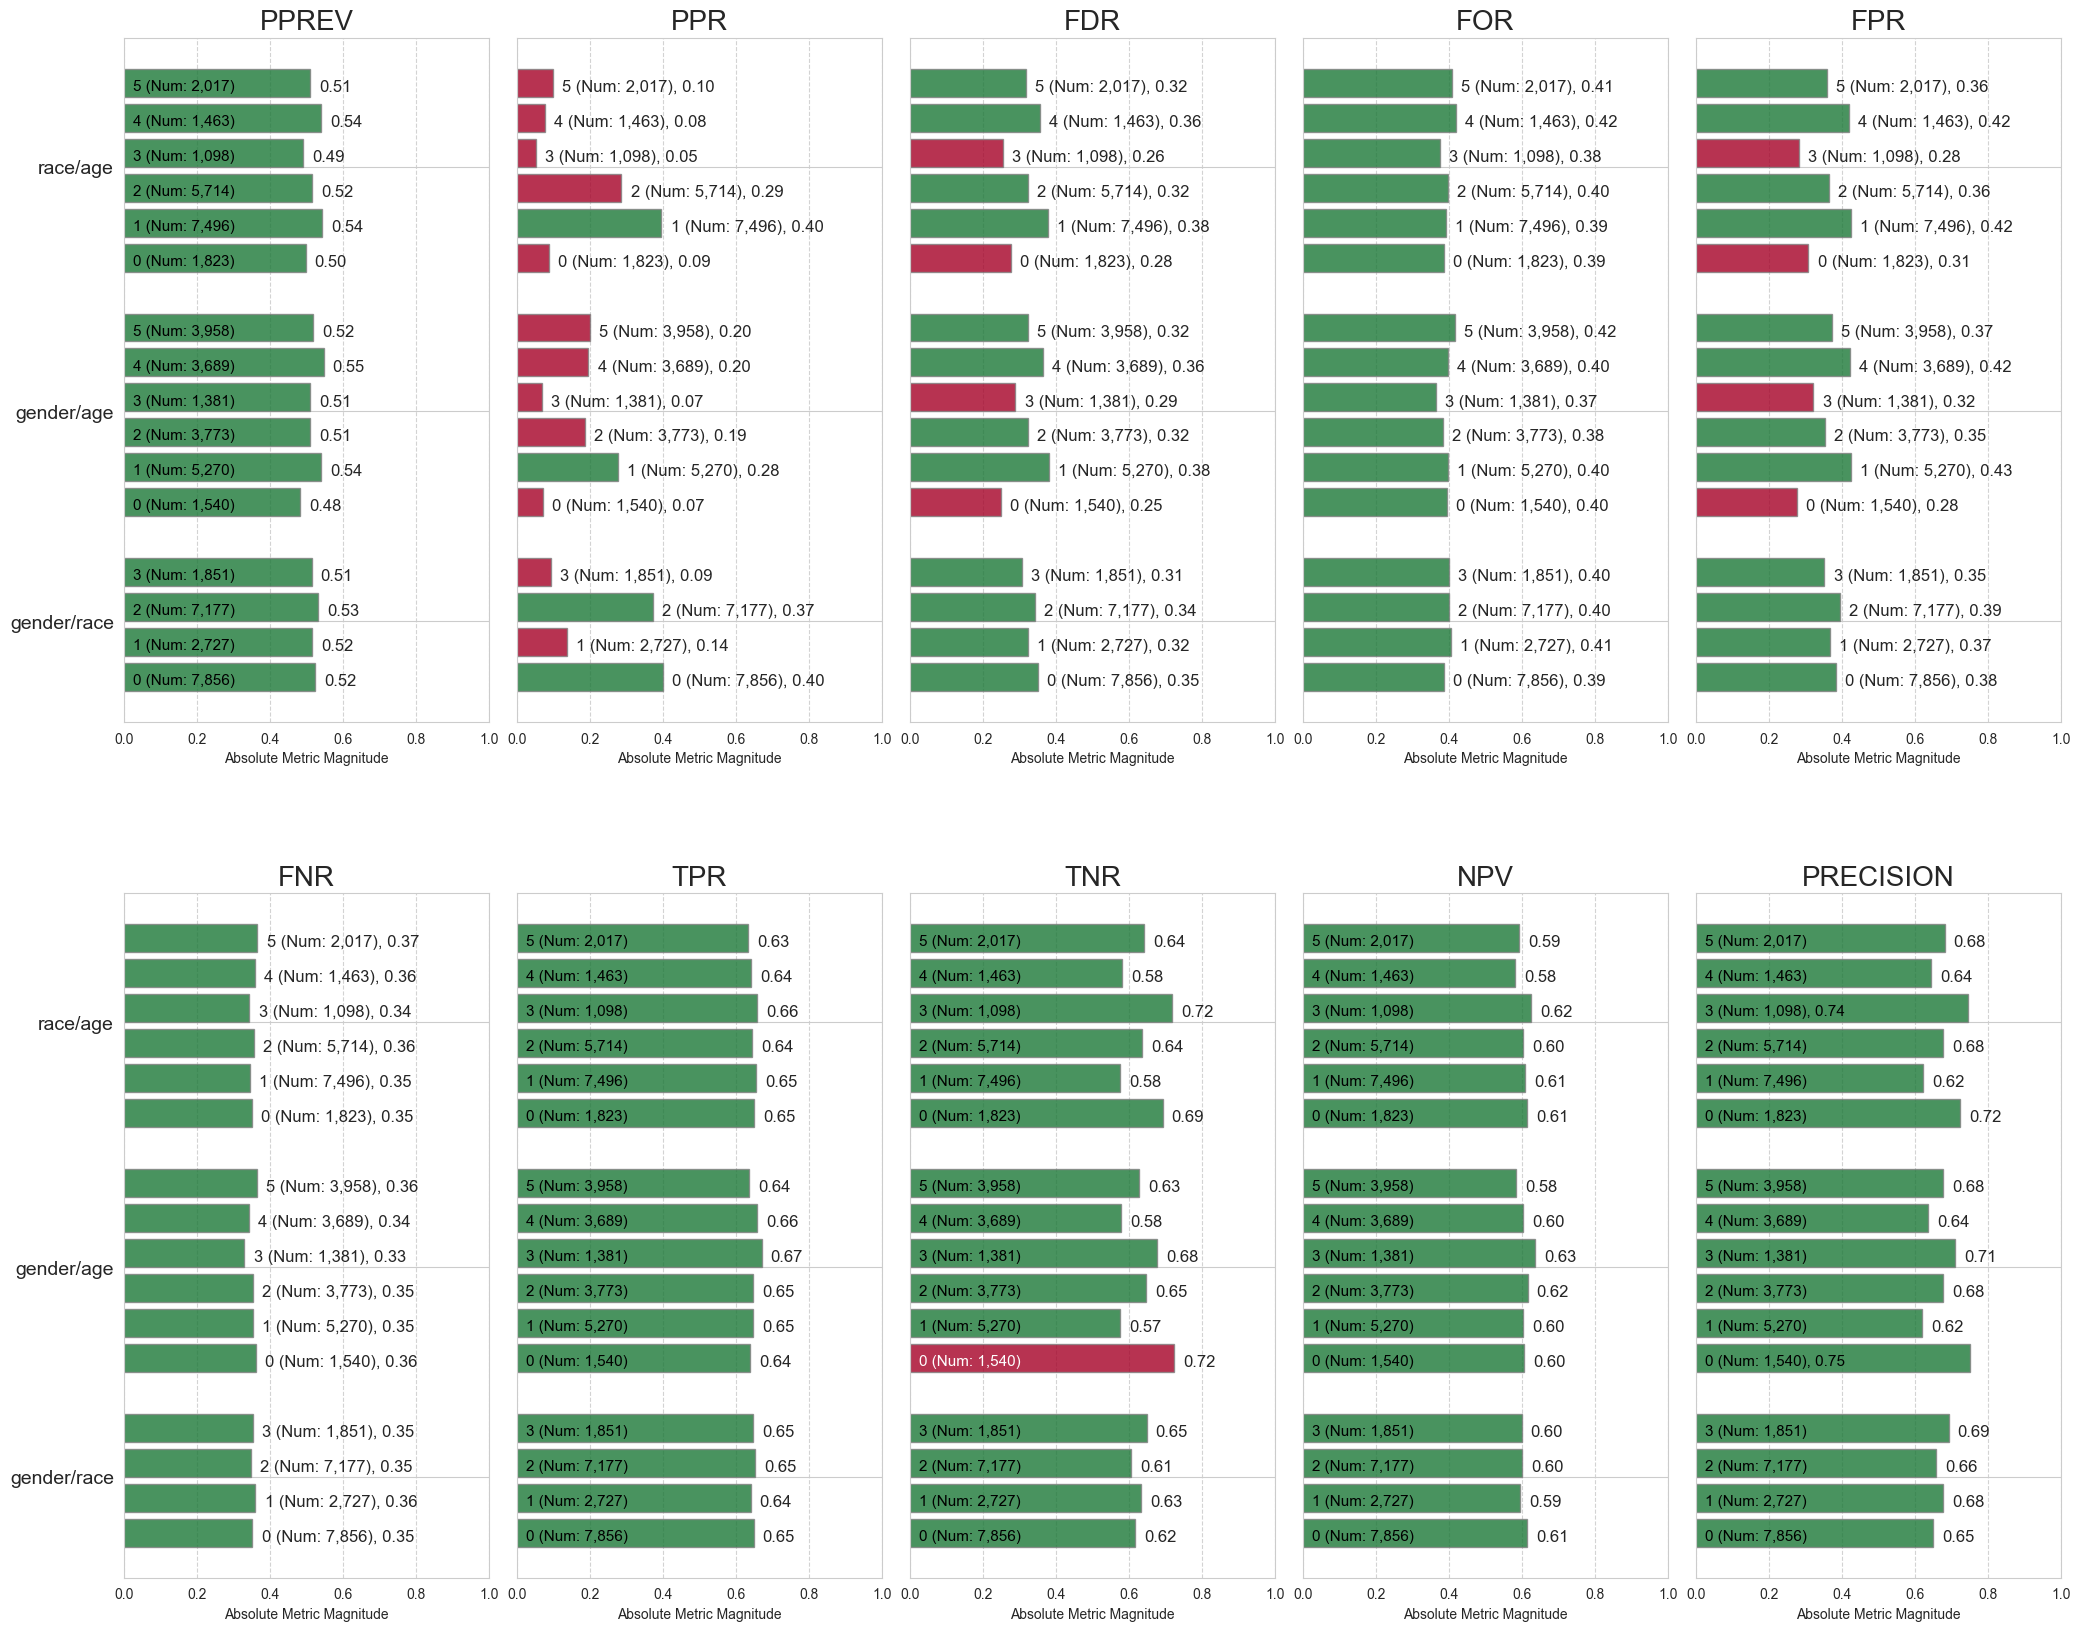

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1     gender/age               False           True   
1         0      binary 0/1    gender/race               False           True   
2         0      binary 0/1       race/age               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False       False        True        True        True       False   
1        True        True        True        True        True        True   
2       False       False        True        True        True        True   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0        True              True         False           True           False   
1        True              True          True           True            True   
2        True              True         False           True           False   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                 True  
2                  False                False

<Figure size 640x480 with 0 Axes>

In [20]:
df_test_fairlearn = post_process_group_threshold_fairlearn(df_num_int, protected_attributes_int, target,list_of_disparities, priv)
# plot_audit(df_test_int, protected_attributes_int)
# plot_audit(df_test_fairlearn, protected_attributes_int)

---------- Model name:  Catboost ----------

[INFO] 2024-11-21 15:14:38 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-21 15:14:38 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-21 15:14:38 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-21 15:14:38 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-21 15:14:38 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-21 15:14:38 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-21 15:14:38 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-21 15:14:38 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-21 15:14:38 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-21 15:14:38 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-21 15:14:38 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-21 15:14:38 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-21 15:14:38 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-21 15:14:38 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-21 15:14:38 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-21 15:14:38 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-21 15:14:38 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-21 15:14:38 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


Accuracy score test corrected:
0.5006


attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0     gender/age               0      0.68  0.69  0.67  0.37  0.27  0.33   
1     gender/age               1      0.62  0.56  0.67  0.41  0.35  0.33   
2     gender/age               2      0.65  0.62  0.68  0.39  0.31  0.32   
3     gender/age               3      0.67  0.66  0.67  0.37  0.29  0.33   
4     gender/age               4      0.62  0.56  0.68  0.42  0.34  0.32   
5     gender/age               5      0.63  0.60  0.67  0.43  0.31  0.33   

    fnr   npv  precision   ppr  pprev  prev  
0  0.31  0.63       0.73  0.09   0.53  0.57  
1  0.44  0.59       0.65  0.26   0.45  0.52  
2  0.38  0.61       0.69  0.20   0.48  0.53  
3  0.34  0.63       0.71  0.08   0.51  0.54  
4  0.44  0.58       0.66  0.18   0.45  0.53  
5  0.40  0.57       0.69  0.20   0.48  0.55

Majority class for:  gender/age  is: 1
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  for_disparity  \
0     gender/age               0           0.76           0.70           0.91   
1     gender/age               1           1.00           1.00           1.00   
2     gender/age               2           0.89           0.87           0.95   
3     gender/age               3           0.84           0.78           0.91   
4     gender/age               4           0.97           1.00           1.02   
5     gender/age               5           0.89           0.92           1.04   

   fpr_disparity  npv_disparity  ppr_disparity  pprev_disparity  \
0           1.01           1.06           0.35             1.19   
1           1.00           1.00           1.00             1.00   
2           0.98           1.03           0.77             1.07   
3           1.00           1.06           0.30             1.13   
4           1.00           0.98           0.70             1.00   
5           1.02           0.97           0.80             1.06   

   precision_disparity  tnr_disparity  tpr_disparity  
0                 1.13           1.00           1.23  
1                 1.00           1.00           1.00  
2                 1.06           1.01           1.10  
3                 1.09           1.00           1.17  
4                 1.02           1.00           1.00  
5                 1.06           0.99           1.06

             fnr_disparity
gender/age           0.854
gender/race            NaN
race/age               NaN
Overall average for fnr_disparity:  0.854


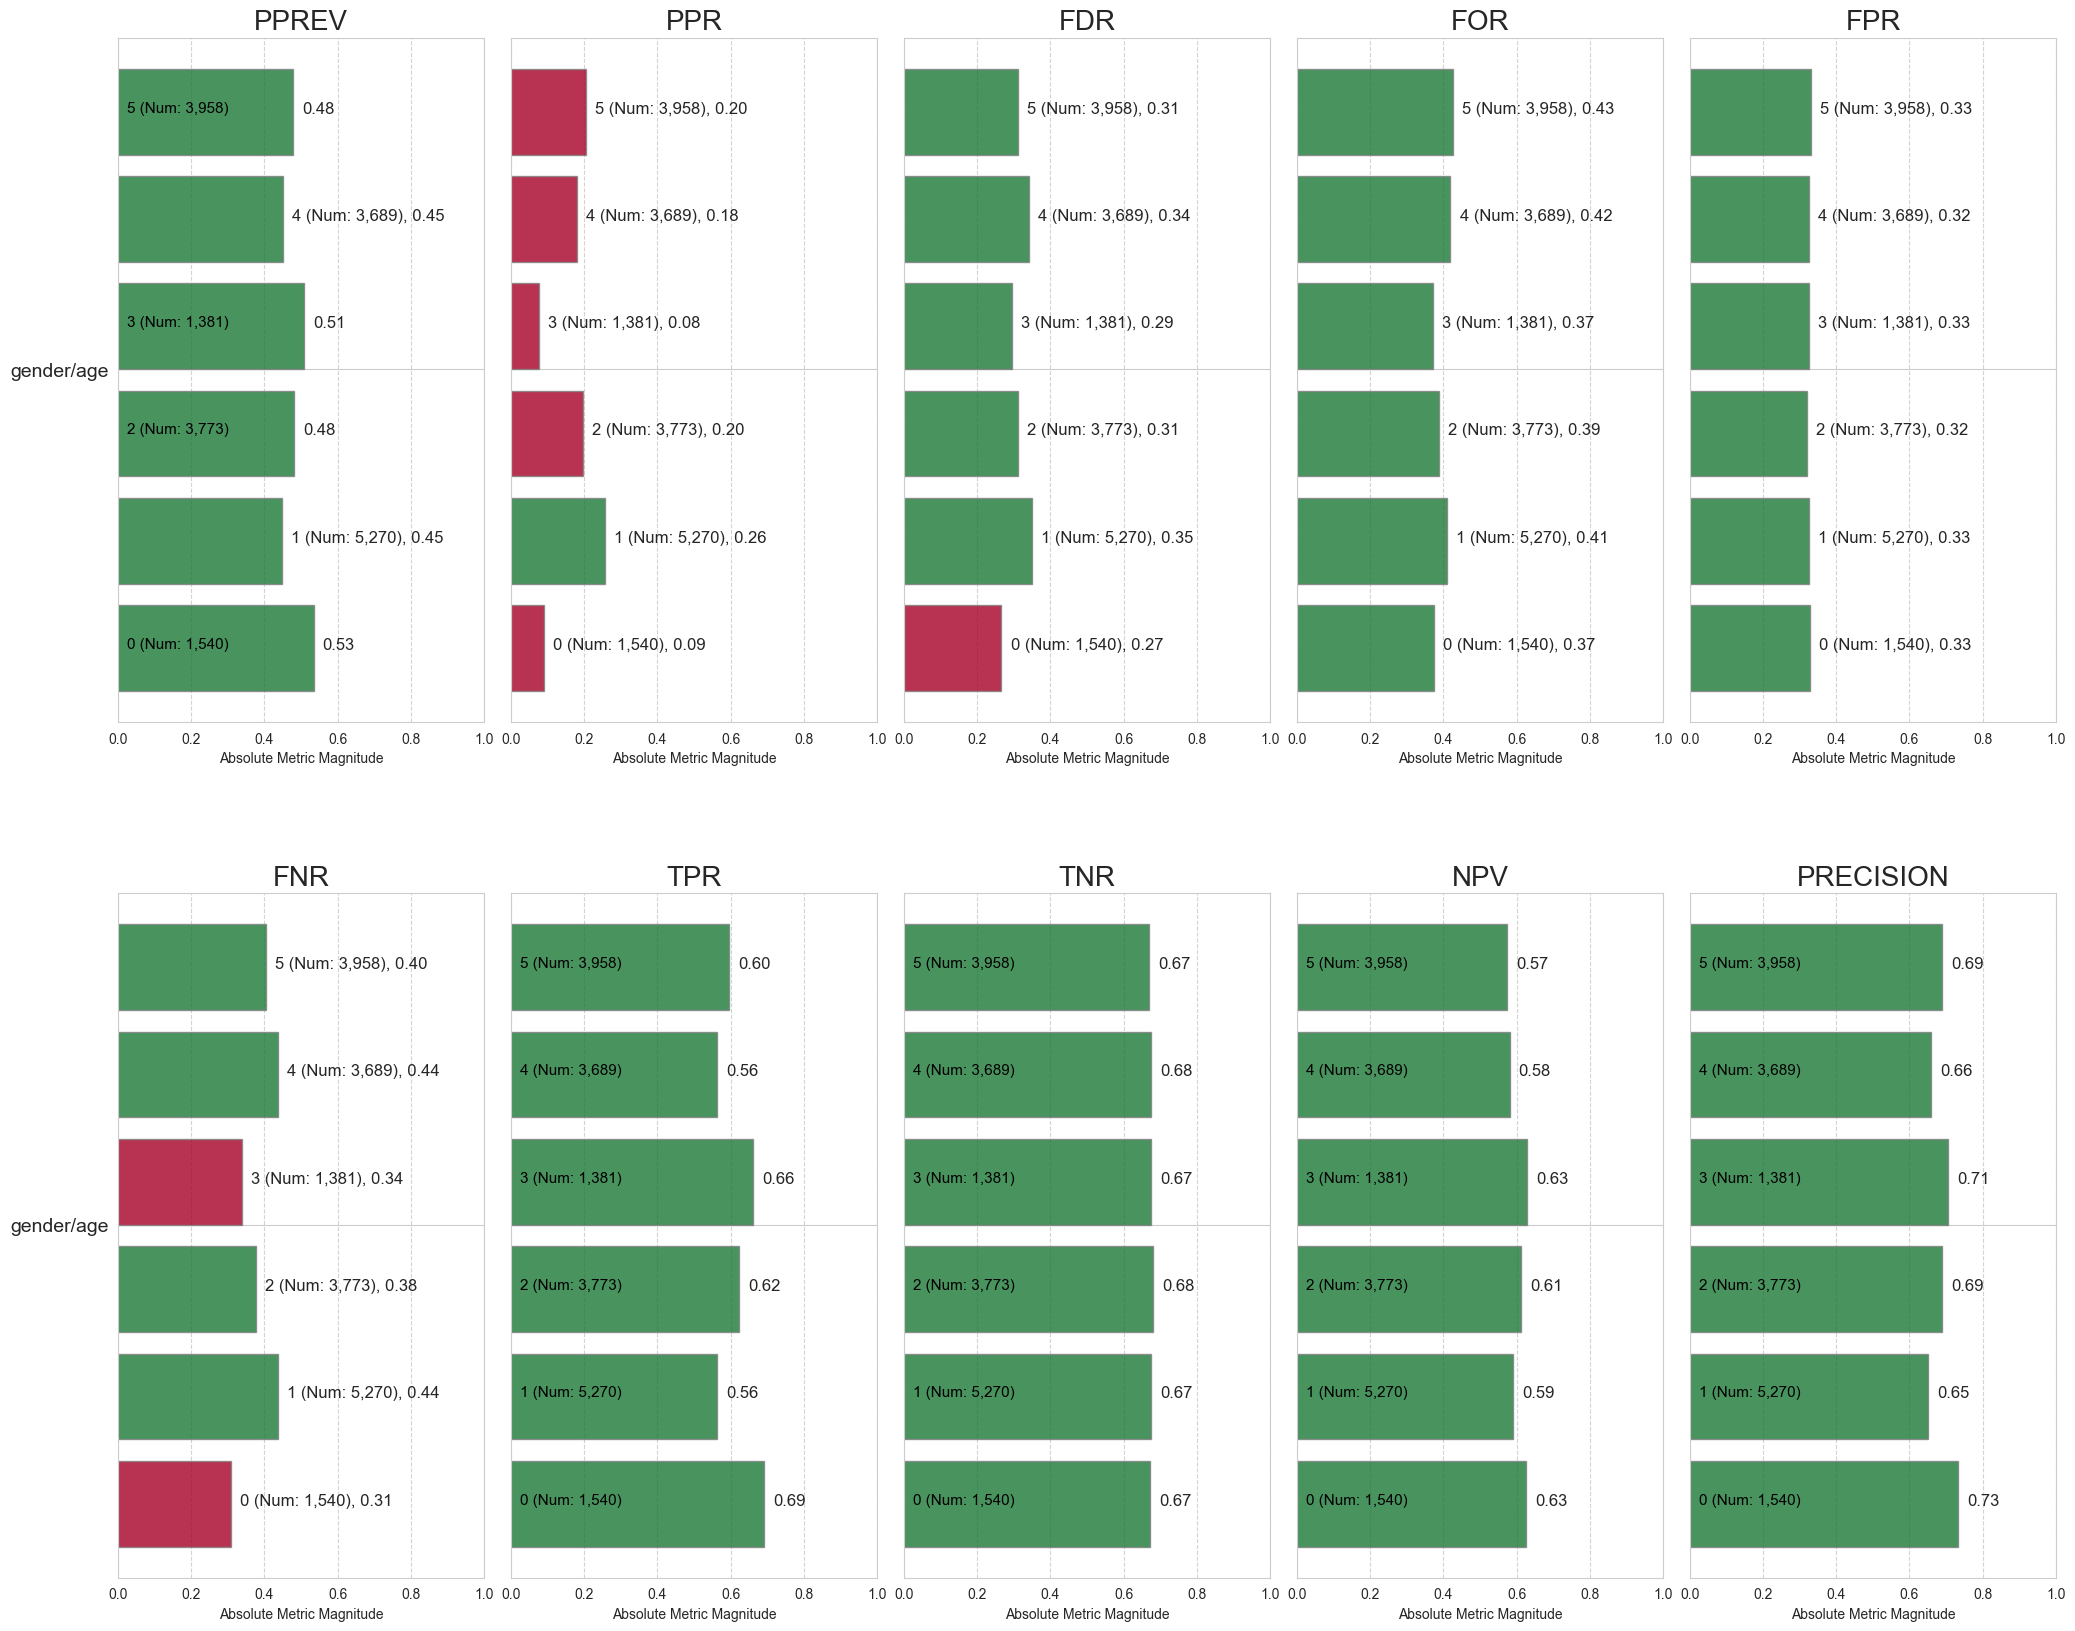

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1     gender/age               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False        True        True       False        True        True   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0        True              True         False          False            True   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False

---------- Model name:  Catboost ----------

[INFO] 2024-11-21 15:14:50 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-21 15:14:50 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-21 15:14:50 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-21 15:14:50 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-21 15:14:50 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-21 15:14:50 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-21 15:14:50 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-21 15:14:50 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-21 15:14:50 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-21 15:14:50 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-21 15:14:50 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-21 15:14:50 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


Accuracy score test corrected:
0.5004


attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0    gender/race               0      0.64  0.60  0.68  0.39  0.33  0.32   
1    gender/race               1      0.63  0.58  0.69  0.42  0.30  0.31   
2    gender/race               2      0.63  0.59  0.67  0.42  0.33  0.33   
3    gender/race               3      0.64  0.60  0.68  0.42  0.30  0.32   

    fnr   npv  precision   ppr  pprev  prev  
0  0.40  0.61       0.67  0.40   0.47  0.52  
1  0.42  0.58       0.70  0.14   0.46  0.55  
2  0.41  0.58       0.67  0.37   0.47  0.54  
3  0.40  0.58       0.70  0.10   0.47  0.55

Majority class for:  gender/race  is: 0
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  for_disparity  \
0    gender/race               0           1.00           1.00           1.00   
1    gender/race               1           0.93           1.05           1.06   
2    gender/race               2           0.99           1.03           1.06   
3    gender/race               3           0.91           1.00           1.06   

   fpr_disparity  npv_disparity  ppr_disparity  pprev_disparity  \
0           1.00           1.00           1.00             1.00   
1           0.94           0.96           0.34             0.97   
2           1.02           0.96           0.91             1.00   
3           0.97           0.96           0.24             1.01   

   precision_disparity  tnr_disparity  tpr_disparity  
0                 1.00           1.00           1.00  
1                 1.03           1.03           0.97  
2                 1.00           0.99           0.98  
3                 1.04           1.01           1.00

             fnr_disparity
gender/age             NaN
gender/race       1.026667
race/age               NaN
Overall average for fnr_disparity:  1.027


<Figure size 640x480 with 0 Axes>

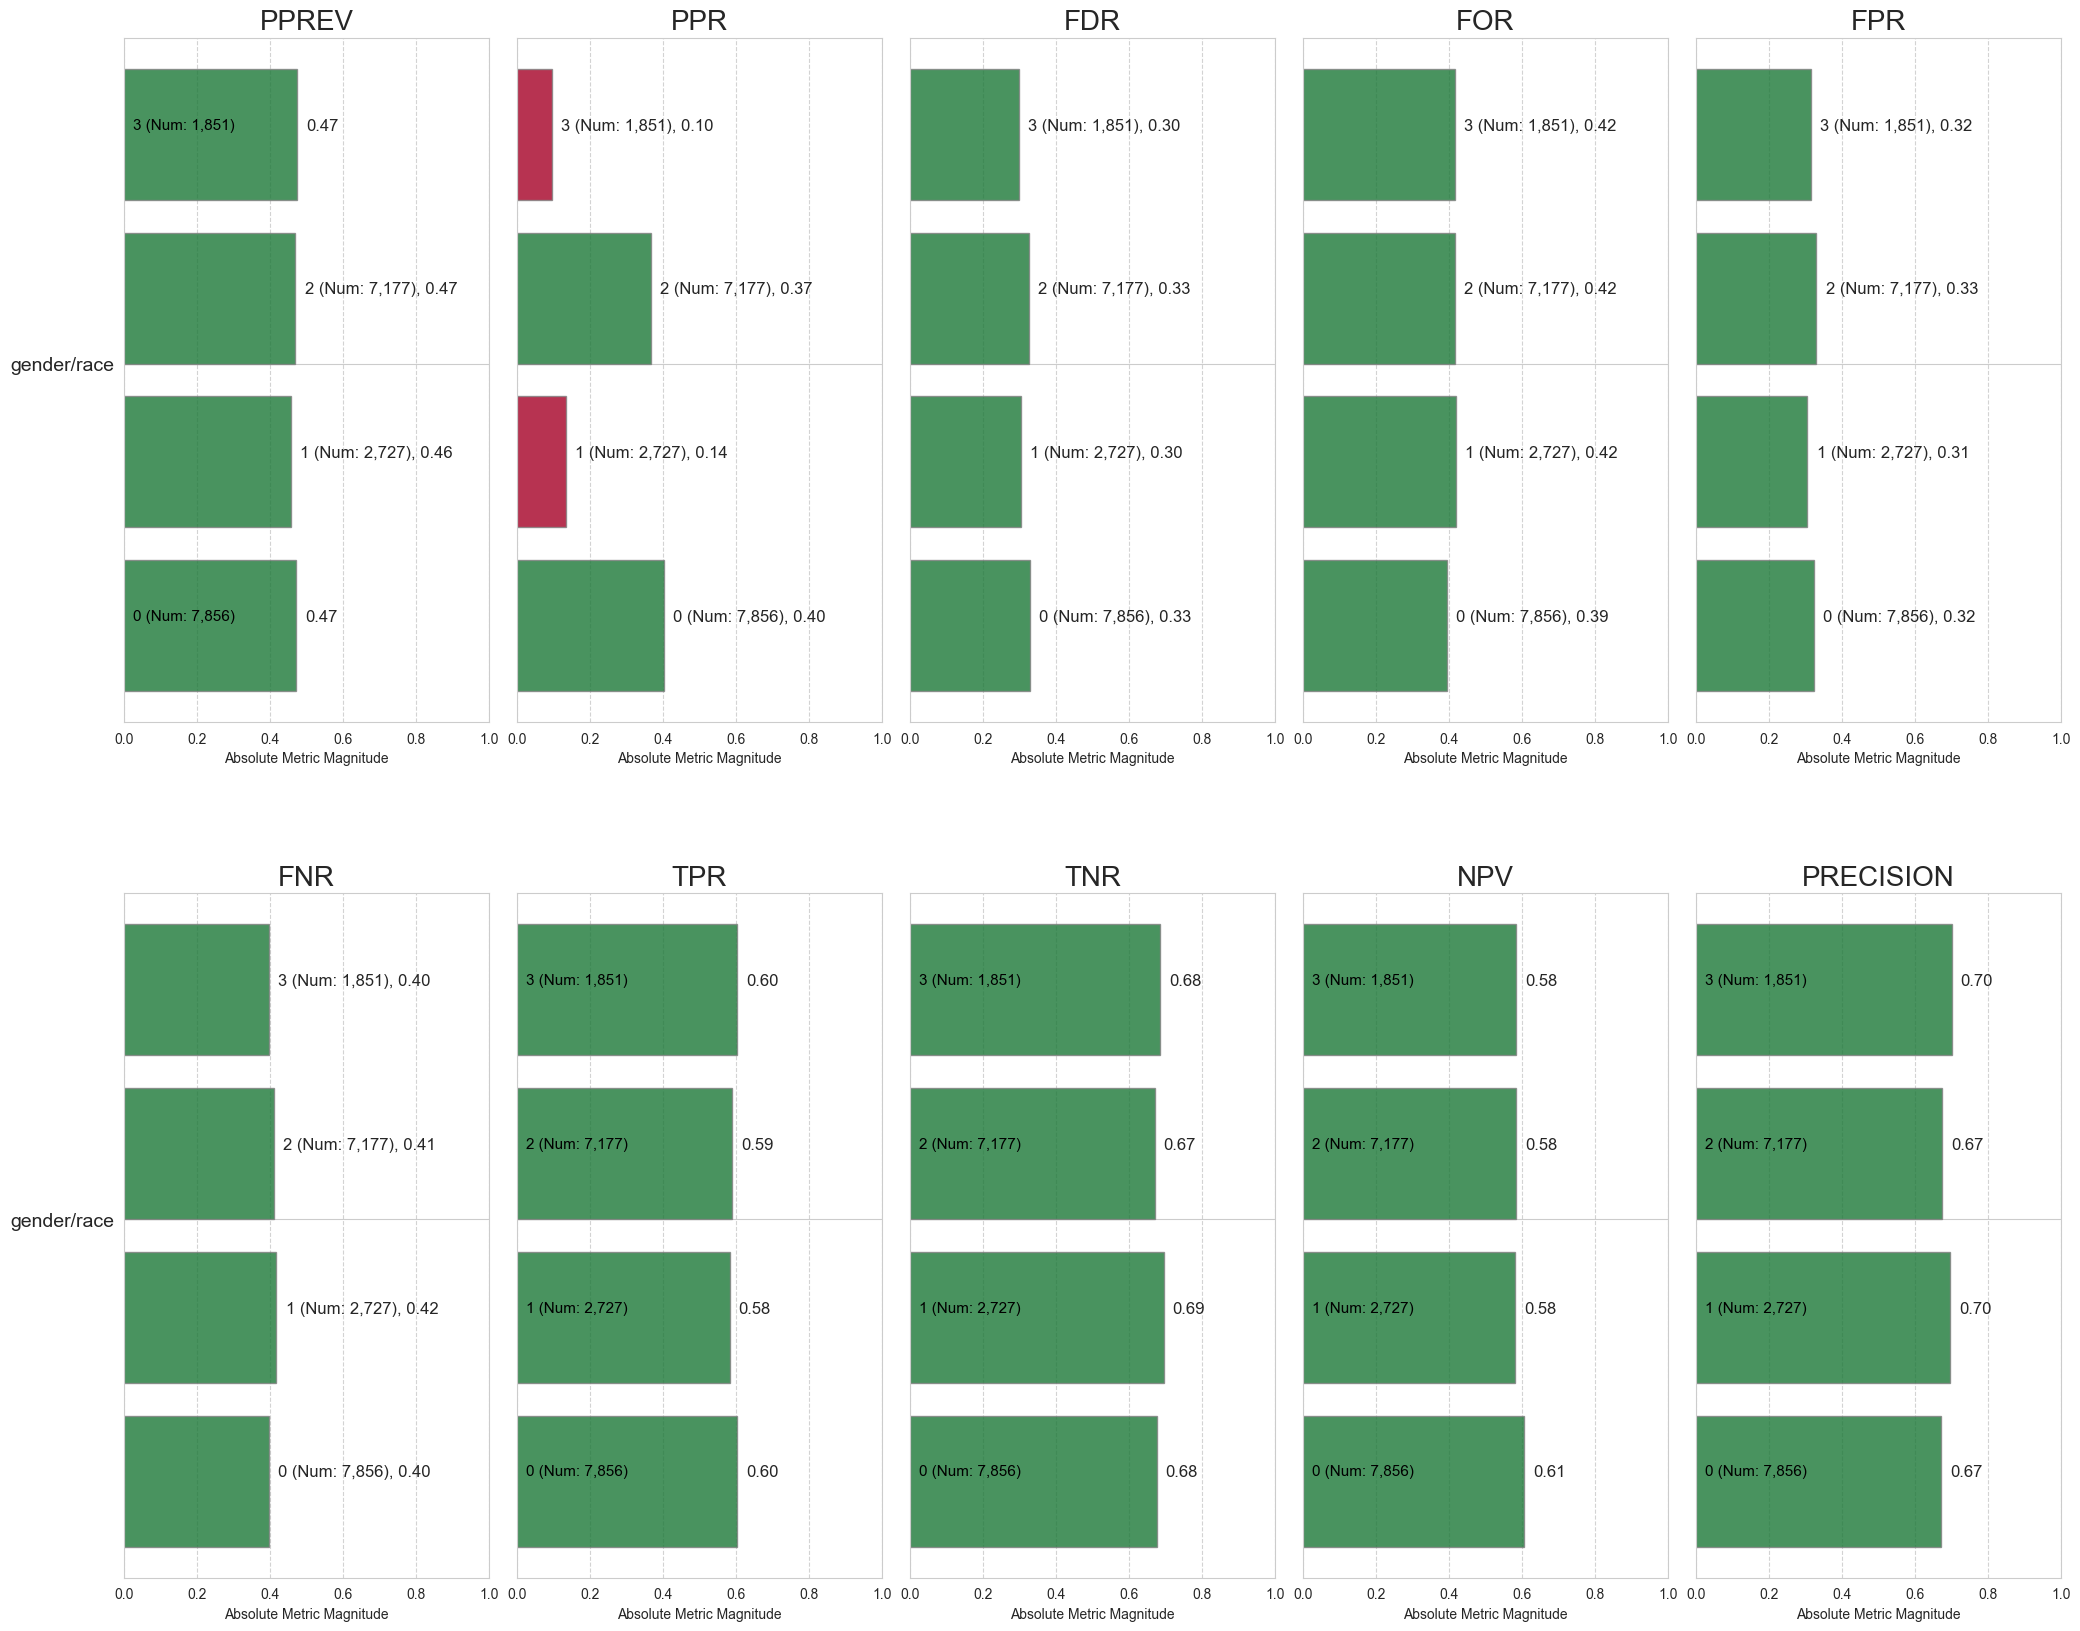

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1    gender/race               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0        True        True        True        True        True        True   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0        True              True          True           True            True   

   Unsupervised Fairness  Supervised Fairness  
0                  False                 True

---------- Model name:  Catboost ----------

[INFO] 2024-11-21 15:15:03 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-21 15:15:03 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-21 15:15:03 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-21 15:15:03 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-21 15:15:03 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-21 15:15:03 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-21 15:15:03 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-21 15:15:03 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-21 15:15:03 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-21 15:15:03 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-21 15:15:03 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-21 15:15:03 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-21 15:15:03 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-21 15:15:03 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-21 15:15:03 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-21 15:15:03 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-21 15:15:03 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-21 15:15:03 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


Accuracy score test corrected:
0.5010


attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0       race/age               0      0.67  0.69  0.65  0.37  0.29  0.35   
1       race/age               1      0.62  0.56  0.68  0.41  0.35  0.32   
2       race/age               2      0.64  0.60  0.68  0.41  0.31  0.32   
3       race/age               3      0.68  0.67  0.70  0.37  0.26  0.30   
4       race/age               4      0.61  0.53  0.69  0.44  0.33  0.31   
5       race/age               5      0.63  0.59  0.67  0.42  0.31  0.33   

    fnr   npv  precision   ppr  pprev  prev  
0  0.31  0.63       0.71  0.11   0.54  0.55  
1  0.44  0.59       0.65  0.37   0.45  0.52  
2  0.40  0.59       0.69  0.30   0.48  0.54  
3  0.33  0.63       0.74  0.06   0.51  0.56  
4  0.47  0.56       0.67  0.07   0.43  0.54  
5  0.41  0.58       0.69  0.10   0.47  0.55

Majority class for:  race/age  is: 1
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  for_disparity  \
0       race/age               0           0.82           0.71           0.90   
1       race/age               1           1.00           1.00           1.00   
2       race/age               2           0.90           0.91           1.00   
3       race/age               3           0.75           0.76           0.91   
4       race/age               4           0.94           1.07           1.08   
5       race/age               5           0.90           0.94           1.03   

   fpr_disparity  npv_disparity  ppr_disparity  pprev_disparity  \
0           1.07           1.07           0.29             1.20   
1           1.00           1.00           1.00             1.00   
2           1.00           1.00           0.81             1.06   
3           0.92           1.06           0.16             1.13   
4           0.94           0.94           0.19             0.95   
5           1.00           0.98           0.28             1.05   

   precision_disparity  tnr_disparity  tpr_disparity  
0                 1.09           0.97           1.23  
1                 1.00           1.00           1.00  
2                 1.05           1.00           1.07  
3                 1.13           1.04           1.19  
4                 1.03           1.03           0.94  
5                 1.06           1.00           1.05

             fnr_disparity
gender/age             NaN
gender/race            NaN
race/age             0.878
Overall average for fnr_disparity:  0.878


<Figure size 640x480 with 0 Axes>

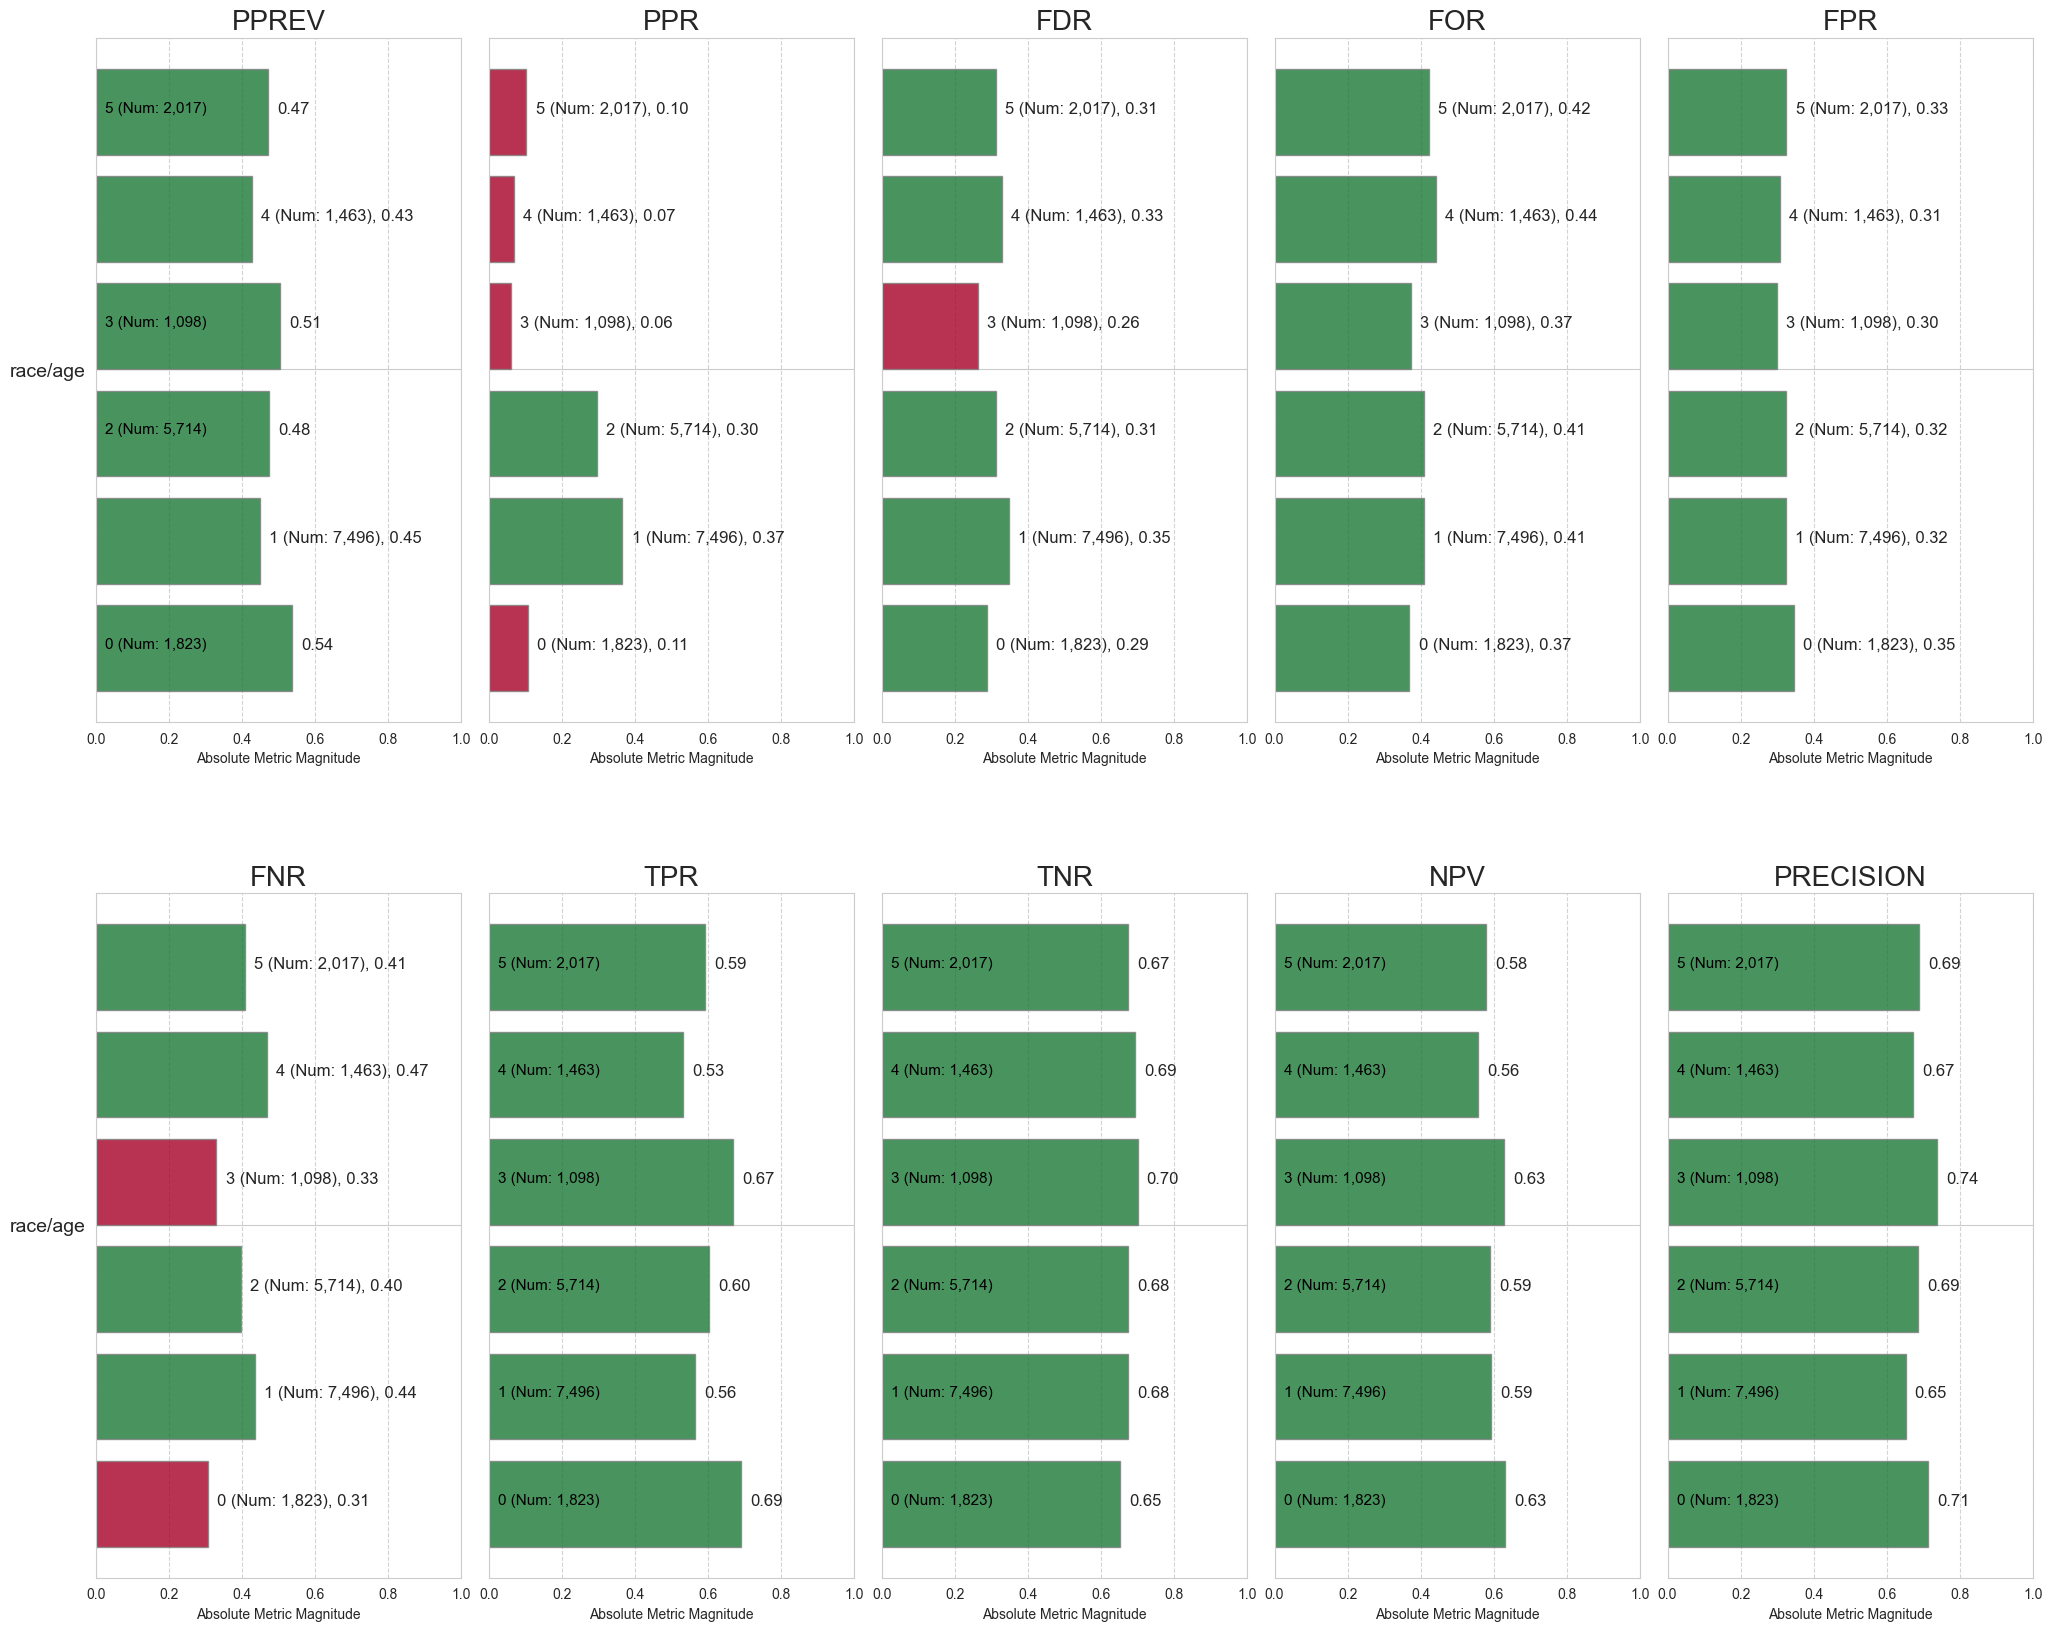

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1       race/age               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False        True        True       False        True        True   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0        True              True         False          False            True   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False

<Figure size 640x480 with 0 Axes>

In [14]:
df_test_aequitas = post_process_group_threshold_aequitas(df_num_int, 'gender/age', target, list_of_disparities, priv)
df_test_aequitas = post_process_group_threshold_aequitas(df_num_int, 'gender/race', target,list_of_disparities, priv)
df_test_aequitas = post_process_group_threshold_aequitas(df_num_int, 'race/age', target,list_of_disparities, priv)

---------- Model name:  Catboost ----------

Privileged groups:  [{'gender/race': 0}]
Unprivileged groups:  [{'gender/race': 3}, {'gender/race': 1}, {'gender/race': 2}]
Accuracy score test corrected:
0.6307


attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0     gender/race               0      0.63  0.74  0.50  0.36  0.38  0.50   
1     gender/race               1      0.64  0.76  0.51  0.36  0.35  0.49   
2     gender/race               2      0.63  0.74  0.49  0.38  0.37  0.51   
3     gender/race               3      0.64  0.75  0.51  0.37  0.35  0.49   
4      gender/age               0      0.67  0.81  0.50  0.34  0.32  0.50   
5      gender/age               1      0.61  0.72  0.50  0.38  0.39  0.50   
6      gender/age               2      0.64  0.76  0.50  0.35  0.36  0.50   
7      gender/age               3      0.66  0.78  0.52  0.33  0.34  0.48   
8      gender/age               4      0.61  0.70  0.51  0.40  0.39  0.49   
9      gender/age               5      0.64  0.77  0.48  0.37  0.36  0.52   
10       race/age               0      0.66  0.79  0.50  0.34  0.34  0.50   
11       race/age               1      0.61  0.71  0.51  0.38  0.39  0.49   
12       race/age               2      0.64  0.77  0.48  0.36  0.36  0.52   
13       race/age               3      0.68  0.79  0.54  0.33  0.32  0.46   
14       race/age               4      0.61  0.72  0.49  0.40  0.38  0.51   
15       race/age               5      0.65  0.76  0.51  0.36  0.35  0.49   

     fnr   npv  precision   ppr  pprev  prev  
0   0.26  0.64       0.62  0.40   0.63  0.52  
1   0.24  0.64       0.65  0.14   0.63  0.55  
2   0.26  0.62       0.63  0.37   0.63  0.54  
3   0.25  0.63       0.65  0.09   0.63  0.55  
4   0.19  0.66       0.68  0.08   0.67  0.57  
5   0.28  0.62       0.61  0.26   0.61  0.52  
6   0.24  0.65       0.64  0.19   0.64  0.53  
7   0.22  0.67       0.66  0.07   0.64  0.54  
8   0.30  0.60       0.61  0.18   0.60  0.53  
9   0.23  0.63       0.64  0.21   0.66  0.55  
10  0.21  0.66       0.66  0.10   0.66  0.55  
11  0.29  0.62       0.61  0.37   0.60  0.52  
12  0.23  0.64       0.64  0.30   0.65  0.54  
13  0.21  0.67       0.68  0.06   0.65  0.56  
14  0.28  0.60       0.62  0.07   0.62  0.54  
15  0.24  0.64       0.65  0.10   0.63  0.55

Majority class for:  gender/race  is: 0
Majority class for:  gender/age  is: 1
Majority class for:  race/age  is: 1
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0     gender/race               0           1.00           1.00   
1     gender/race               1           0.93           0.95   
2     gender/race               2           0.98           1.02   
3     gender/race               3           0.91           0.98   
4      gender/age               0           0.81           0.69   
5      gender/age               1           1.00           1.00   
6      gender/age               2           0.92           0.84   
7      gender/age               3           0.87           0.77   
8      gender/age               4           0.98           1.07   
9      gender/age               5           0.90           0.82   
10       race/age               0           0.86           0.70   
11       race/age               1           1.00           1.00   
12       race/age               2           0.92           0.79   
13       race/age               3           0.81           0.70   
14       race/age               4           0.95           0.96   
15       race/age               5           0.88           0.83   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.00           1.00           1.00           1.00   
1            1.01           0.98           1.00           0.35   
2            1.05           1.01           0.97           0.92   
3            1.03           0.97           0.98           0.24   
4            0.89           0.99           1.07           0.32   
5            1.00           1.00           1.00           1.00   
6            0.93           0.99           1.04           0.75   
7            0.88           0.96           1.07           0.28   
8            1.06           0.98           0.96           0.68   
9            0.99           1.05           1.01           0.81   
10           0.88           1.02           1.07           0.27   
11           1.00           1.00           1.00           1.00   
12           0.94           1.05           1.04           0.83   
13           0.85           0.94           1.09           0.16   
14           1.05           1.03           0.97           0.20   
15           0.95           0.98           1.03           0.28   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              1.00                 1.00           1.00           1.00  
1              1.01                 1.05           1.02           1.02  
2              1.01                 1.01           0.99           0.99  
3              1.00                 1.05           1.03           1.01  
4              1.10                 1.12           1.01           1.12  
5              1.00                 1.00           1.00           1.00  
6              1.04                 1.05           1.01           1.06  
7              1.05                 1.09           1.04           1.09  
8              0.98                 1.01           1.02           0.97  
9              1.08                 1.06           0.95           1.07  
10             1.10                 1.09           0.98           1.13  
11             1.00                 1.00           1.00           1.00  
12             1.08                 1.05           0.95           1.09  
13             1.07                 1.13           1.06           1.12  
14             1.03                 1.03           0.97           1.02  
15             1.05                 1.08           1.01           1.07

             fnr_disparity
gender/age        0.838000
gender/race       0.983333
race/age          0.796000
Overall average for fnr_disparity:  0.872


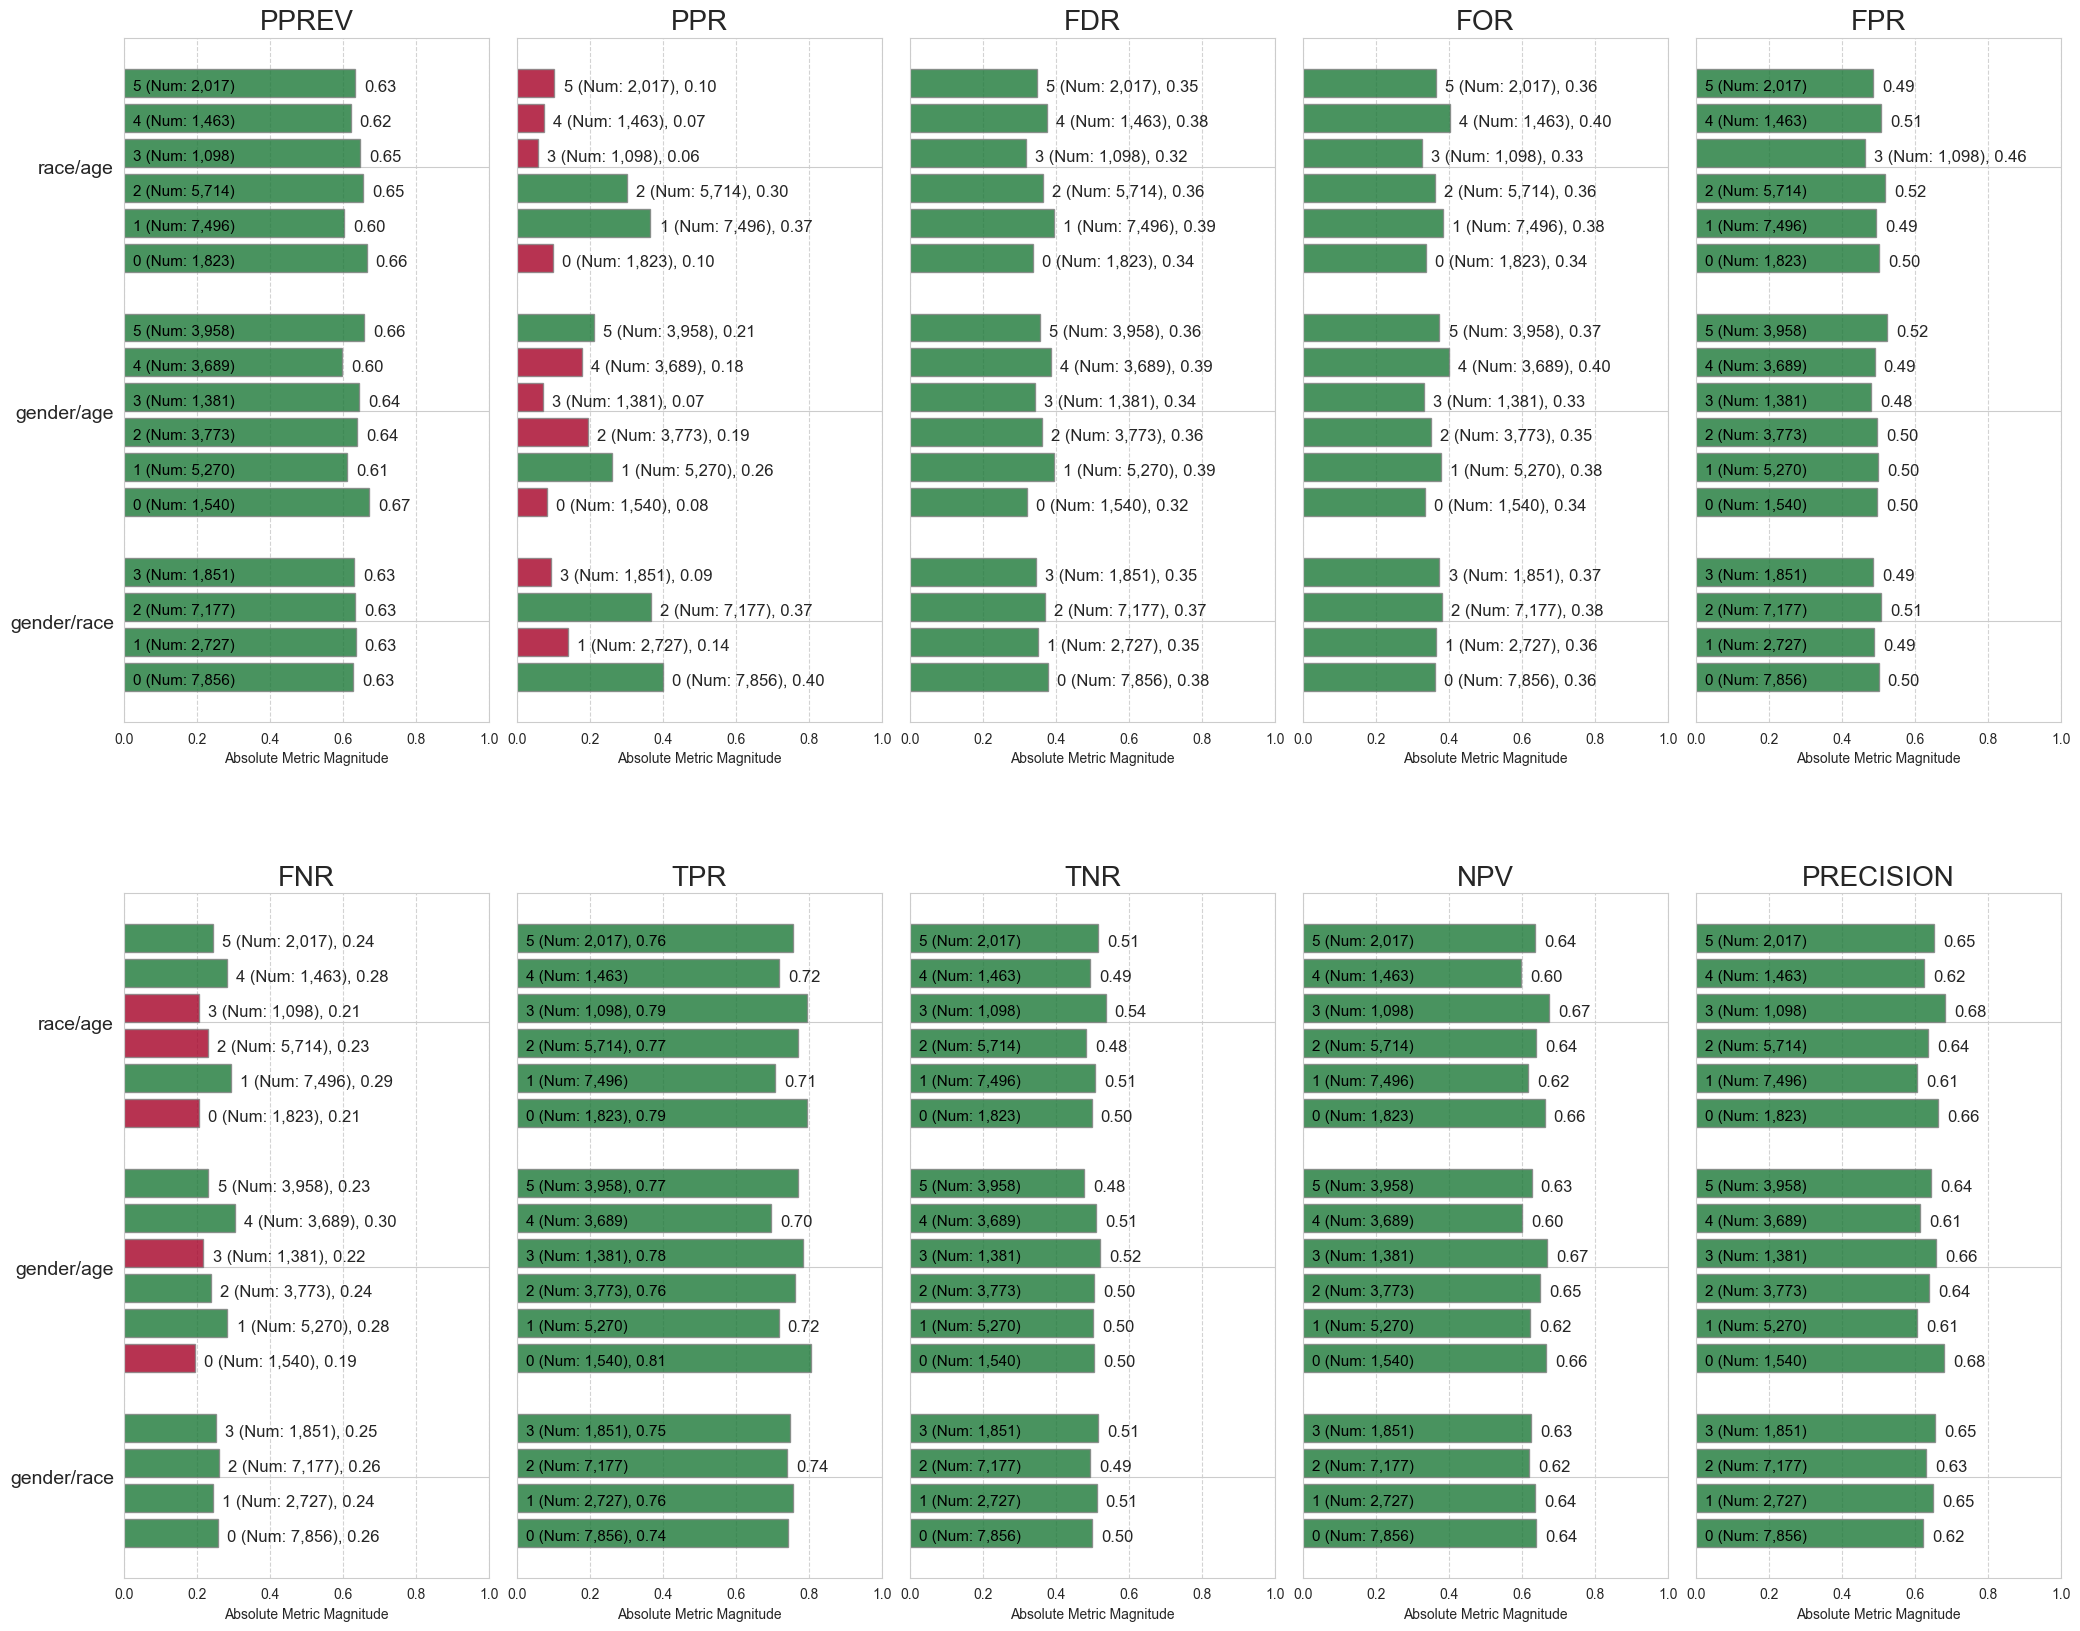

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1     gender/age               False           True   
1         0      binary 0/1    gender/race               False           True   
2         0      binary 0/1       race/age               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0        True        True        True       False        True        True   
1        True        True        True        True        True        True   
2        True        True        True       False        True        True   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0        True              True          True          False            True   
1        True              True          True           True            True   
2        True              True          True          False            True   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                 True  
2                  False                False

score  label_value gender/race gender/age race/age  rank_abs  \
101707    1.0            0           2          4        1         1   
3322      1.0            1           0          0        0         2   
80267     1.0            0           0          2        2         3   
63347     1.0            1           3          5        5         4   
47829     1.0            0           2          4        1         5   
...       ...          ...         ...        ...      ...       ...   
18052     0.0            0           2          5        2     19607   
50380     0.0            0           1          2        5     19608   
56209     0.0            1           2          4        1     19609   
79838     0.0            0           1          1        4     19610   
99543     0.0            0           0          0        0     19611   

        rank_pct  binary_score  binary_fpr  binary_fnr  binary_tnr  \
101707  0.000051             1         1.0         NaN         1.0   
3322    0.000102             1         0.0         NaN         0.0   
80267   0.000153             1         1.0         NaN         1.0   
63347   0.000204             1         0.0         NaN         0.0   
47829   0.000255             1         1.0         NaN         1.0   
...          ...           ...         ...         ...         ...   
18052   0.999796             0         NaN         0.0         NaN   
50380   0.999847             0         NaN         0.0         NaN   
56209   0.999898             0         NaN         1.0         NaN   
79838   0.999949             0         NaN         0.0         NaN   
99543   1.000000             0         NaN         0.0         NaN   

        binary_fdr  binary_tpr  binary_pprev  binary_precision  binary_for  \
101707         1.0         NaN             1               1.0         NaN   
3322           0.0         NaN             1               0.0         NaN   
80267          1.0         NaN             1               1.0         NaN   
63347          0.0         NaN             1               0.0         NaN   
47829          1.0         NaN             1               1.0         NaN   
...            ...         ...           ...               ...         ...   
18052          NaN         0.0             0               NaN         0.0   
50380          NaN         0.0             0               NaN         0.0   
56209          NaN         1.0             0               NaN         1.0   
79838          NaN         0.0             0               NaN         0.0   
99543          NaN         0.0             0               NaN         0.0   

        binary_npv  binary_ppr  
101707         NaN           1  
3322           NaN           1  
80267          NaN           1  
63347          NaN           1  
47829          NaN           1  
...            ...         ...  
18052          0.0           0  
50380          0.0           0  
56209          1.0           0  
79838          0.0           0  
99543          0.0           0  

[19611 rows x 18 columns]

<Figure size 640x480 with 0 Axes>

In [23]:
post_process_eq_ods(data=df_num_int, attributes=protected_attributes_int, target=target,priv=priv, list_of_disparities=list_of_disparities)

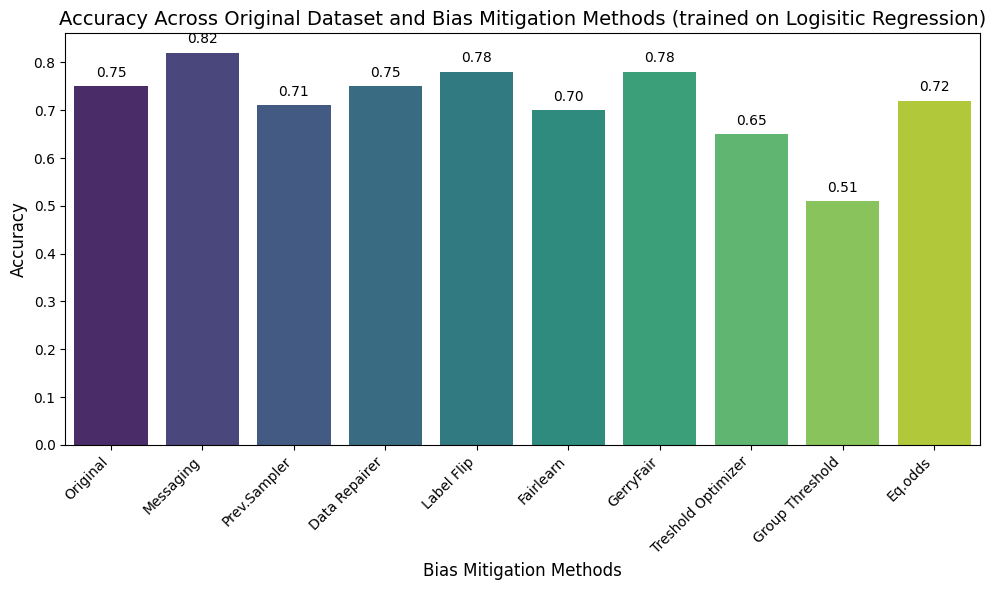

In [6]:
methods = [
    "Original", 
    "Messaging", "Prev.Sampler", "Data Repairer", 
    "Label Flip", "Fairlearn", "GerryFair",
    "Treshold Optimizer", "Group Threshold", "Eq.odds"
]
accuracy = [0.75,0.82,0.71,0.75,0.78,0.7,0.78,0.65,0.51,0.72]  # Example accuracies

# Create a DataFrame
df = pd.DataFrame({
    "Methods": methods,
    "Accuracy": accuracy
})

# Plot settings
plt.figure(figsize=(10, 6))
sns.barplot(x="Methods", y="Accuracy", data=df, palette="viridis")

# Add accuracy values to bars
for i, value in enumerate(df["Accuracy"]):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center', fontsize=10, color='black')

# Add labels and title
plt.title("Accuracy Across Original Dataset and Bias Mitigation Methods (trained on Logisitic Regression)", fontsize=14)
plt.xlabel("Bias Mitigation Methods", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)

# Show plot
plt.tight_layout()
plt.show()